## MCC NMIBC Pre-repeat Urine MRD analysis

In [178]:
library(ggplot2)
library(tidyverse)
library(ComplexHeatmap)
library(maftools)
library(RColorBrewer)
library(readxl)
library(stats)
library(pROC)
library(stringr)
source("~/Desktop/puffin/R/helper_functions.R")
options(stringsAsFactors = FALSE)
options(repr.matrix.max.cols=75, repr.matrix.max.rows=50)
source("../fix_PIDs.R")

# set some defaults
options(stringsAsFactors = FALSE)
options(repr.matrix.max.cols=75, repr.matrix.max.rows=50)
formals(table)$useNA <- "always"
formals(write.csv)$row.names <- FALSE
formals(write.csv)$as.is <- TRUE

print(Sys.time())
print(sessionInfo())

[1] "2023-11-07 11:01:44 PST"
R version 4.3.0 (2023-04-21)
Platform: aarch64-apple-darwin20 (64-bit)
Running under: macOS Ventura 13.5.1

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.3-arm64/Resources/lib/libRblas.0.dylib 
LAPACK: /Library/Frameworks/R.framework/Versions/4.3-arm64/Resources/lib/libRlapack.dylib;  LAPACK version 3.11.0

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

time zone: America/Los_Angeles
tzcode source: internal

attached base packages:
[1] grid      stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] ggsignif_0.6.4        glue_1.6.2            pROC_1.18.4          
 [4] readxl_1.4.3          RColorBrewer_1.1-3    maftools_2.16.0      
 [7] ComplexHeatmap_2.16.0 lubridate_1.9.2       forcats_1.0.0        
[10] stringr_1.5.0         dplyr_1.1.2           purrr_1.0.1          
[13] readr_2.1.4           tidyr_1.3.0           tibble_3.2.1         
[16] ti

## Beacon pipeline data location (3 work orders)
 http://10.10.0.131/lbwfresult/OutputByRun23/221014_A00934_0220_BHCY3YDMXY/dsrun1.7/lbwfresult1.7/
/prednet/data32/OutputByRun32/20231006_LH00191_0042_A22F2CMLT3_runtask_231009012258_b310ac88/dsrun1.7.1/lbwfresult1.7.1/WOP01172_PRDC-MOFFITT-NMIBC-22001
/lbwfresult/OutputByRun32/20231006_LH00191_0041_B22F2C3LT3_runtask_231009012230_1c2b881a/dsrun1.7.1/lbwfresult1.7.1/WOP01172_PRDC-MOFFITT-NMIBC-22001

### pipeline notes on the mrd output file, see deepsea func callMRD and local annotated version of function
- mutationCount = length(variants.f), # count of Beacon sample variants that are somatic, and finalKeep or white.list
- mutationCount.mrd = length(variants.mrd), # number of quality filtered T00 personalized variants detected           
- mutationCount.mrd.f = length(variants.mrd.sig), ## number filtered T00 personal variants that have changed signif. in freuqncy from baseline (i.e. are not germlines mistaken for somatics)                       
- mrd.status = mrd.status,  ## total mrd.score across variants is >1.5
- tumorFraction = tumorFraction, # beacon sample tumorFraction calculated from variants.mrd.sig.f markers, or if none calculated from the other baseline-matching variants

In [179]:
# read in clinical data

## functions for harmonizing input sheets
source("../fix_PIDs.R")

fix_sampleTypes <- function(col){
    #print(table(col, useNA="always"))
    col.new <- gsub("FFPE", "Tissue", col)
    col.new <- gsub("Urine_Supernatant|Supernatant", "Urine", col.new)
    col.new <- gsub("Buffy Coat|PBMC", "Buffy_Coat", col.new)
    print(table(col.new, useNA="always"))
    return(col.new)
}
fix_StudyVisit <- function(col){
    warn_na(col)
    col.new <- sapply(str_split(col, pattern="_"), "[", 2)
    return(col.new)
}


df_clin = read.csv("./clinical_data/NMIBC_clinical_data_merged_2023-10-11.csv", as.is=T) %>%
                mutate(PatientID=as.character(PatientID))
stopifnot(all(!duplicated(df_clin$PatientID)))
print(df_clin$PatientID)
names(df_clin)
table(df_clin$disease.positive) # no clin data on validation cohort samples

 [1] "152237" "161922" "169558" "172530" "173254" "173912" "174091" "174872"
 [9] "175648" "175733" "175980" "176349" "176388" "180264" "182022" "116381"
[17] "165028" "167162" "171374" "171769" "171821" "172153" "172229" "172586"
[25] "172602" "172749" "172851" "173075" "173281" "173334" "173350" "173359"
[33] "173362" "173509" "173975" "173983" "175610" "174083" "174947" "175325"
[41] "175387" "175425" "175492" "175526" "175672" "175725" "175854" "176828"
[49] "176992" "177967" "178886" "175831" "179692" "181439" "181568" "182435"
[57] "182910" "184289" "184485" "184615" "184957" "185014" "185212" "185382"
[65] "185581" "186478" "186652" "187204" "187807" "188867" "189083" "189342"
[73] "190233" "191632" "191692" "192682" "193186"


[1] "PatientID"                                                                                                      
 [2] "has.IndexTURBT"                                                                                                 
 [3] "Age"                                                                                                            
 [4] "Sex"                                                                                                            
 [5] "Race"                                                                                                           
 [6] "Smoking.Status"                                                                                                 
 [7] "ECOG.scoreAt.Repeat.TURBT"                                                                                      
 [8] "Previous.pelvic.XRT"                                                                                            
 [9] "Previous.history.of.NMIBC"                                                                                      
[10] "Progression"                                                                                                    
[11] "Previous.Intravesical.Therapy..choice.None."                                                                    
[12] "Previous.Intravesical.Therapy..choice.BCG."                                                                     
[13] "Previous.Intravesical.Therapy..choice.Gemcitabine.....Docetaxel."                                               
[14] "Previous.Intravesical.Therapy..choice.Mitomycin.C."                                                             
[15] "Other.Intravesical.Therapy"                                                                                     
[16] "Prior.Treatment.Free.Text..1.2.sentence.summary.of.treatment.prior.to.Index.TURBT.inclusive.of.NMIBC.Pathology."
[17] "Index.TURBT.Date"                                                                                               
[18] "IndexHistology"                                                                                                 
[19] "Variant.Histology"                                                                                              
[20] "Index.Stage"                                                                                                    
[21] "IndexGrade"                                                                                                     
[22] "Index.CIS"                                                                                                      
[23] "LVI...35"                                                                                                       
[24] "Immediate.Post.Op.Intravesical.Therapy.Index"                                                                   
[25] "Repeat.TURBT.Date"                                                                                              
[26] "RepeatHistology"                                                                                                
[27] "Variant.Histology.Repeat"                                                                                       
[28] "Repeat.Stage"                                                                                                   
[29] "RepeatGrade"                                                                                                    
[30] "Repeat.CIS"                                                                                                     
[31] "LVI...43"                                                                                                       
[32] "Immediate.Post.Op.Intravesical.Therapy.Repeat"                                                                  
[33] "Induction.Intravesical.Therapy.Administered."                                                                   
[34] "Induction.Intravesical.Therapy.Type."                               


FALSE  TRUE  <NA> 
   15    35    27 

In [180]:
# Master sample list from manifests
df_samples_all = make_names(read_excel("Manifest_data_all_10112023.xlsx", sheet="Sample information real time")) %>%
                    mutate(SampleID.short = make_SIDshort(SampleID, "remove.suffix"),
                           PatientID = as.character(fix_PIDs(PatientID)),
                      StudyVisit2 = fix_StudyVisit(StudyVisit),
                      StudyVisit = gsub(" ","", ifelse(!is.na(StudyVisit2), StudyVisit2, StudyVisit)),
                      SampleType = fix_sampleTypes(SampleType))
table(df_samples_all$SampleType, df_samples_all$StudyVisit, useNA="always")
nrow(df_samples_all) #558
stopifnot(all(!(duplicated(df_samples_all$SampleID.short))))

# Lab QC
df_lab_qc = read.csv("./NMIBC_all_lab_qc_2023-07-30.csv", as.is=T) #253 samples
#df_qc_all = read.csv("./NMIBC_all_lab_qc_2023-09-01.csv", as.is=T) ## needs update, no PIDs here, 455 smaples
stopifnot(all(!duplicated(df_lab_qc$SampleID.short)))
#write.csv(df_qc_all, glue("./NMIBC_all_lab_qc_{Sys.Date()}.csv"), row.names=F)
nrow(df_lab_qc) #253 

SampleID.short format: remove.suffix
 [1] "116381" "152237" "161922" "165028" "167162" "169558" "171374" "171769"
 [9] "171821" "172153" "172229" "172530" "172586" "172602" "172749" "172851"
[17] "173075" "173254" "173281" "173334" "173350" "173359" "173362" "173509"
[25] "173912" "173975" "173983" "174083" "174091" "174872" "174947" "175325"
[33] "175387" "175425" "175492" "175526" "175610" "175648" "175672" "175725"
[41] "175733" "175831" "175854" "175980" "176349" "176388" "176828" "176992"
[49] "177967" "178886" "179692" "180264" "181439" "181568" "182022" "182435"
[57] "182910" "184289" "184485" "184615" "184957" "185014" "185212" "185382"
[65] "185581" "186478" "186652" "187204" "187807" "188867" "189083" "189342"
[73] "190233" "191632" "191692" "192682" "193186"
col.new
        Buffycoat            Plasma            Tissue             Urine 
               73                73               129               142 
Urine Cell Pellet              <NA> 
              141            

                   
                    BenignUrothelium FollowUp1 FollowUp2 FollowUp3 Followup4
  Buffycoat                        0         0         0         0         0
  Plasma                           0         0         0         0         0
  Tissue                           9         0         0         0         0
  Urine                            0        18         9         4         1
  Urine Cell Pellet                0        18         9         4         1
  <NA>                             0         0         0         0         0
                   
                    IndexTURBT PostTURBT Pre-RepeatTURBT RepeatTURBT
  Buffycoat                  0         0              73           0
  Plasma                     0         0              73           0
  Tissue                    72         0               0          48
  Urine                      0        30              77           0
  Urine Cell Pellet          0        29              77           0
  <NA> 

[1] 558

[1] 253

In [79]:
## rerun batch 1+2 old MRD data form 2022
# df_ngsqc.old = read.csv("data_batch1_and_2/Urine-UCP/Urine_post_analysis/PD_12-02-2022_beacon_results/PRDC-MOFFITT-NMIBC-22001_MRD_Info_combined.csv")

# df_ngsqc.old = df_ngsqc.old %>% select(-PatientID) %>%
#                         left_join(df_samples_all %>% select(SampleID.short, StudyVisit, PatientID), by="SampleID.short") %>%
#                         rename("StudyVisit.sample"="StudyVisit") %>% 
#                         mutate(StudyVisit2 = fix_StudyVisit(StudyVisit.sample),
#                                StudyVisit.sample = gsub(" ","", (ifelse(is.na(StudyVisit2), StudyVisit.sample, StudyVisit2))),
#                                #PatientID.old.sample = PatientID.sample,
#                                #PatientID.sample = as.character(fix_PIDs(PatientID.old.sample))
#                               )
# df_ngsqc.old = df_ngsqc.old %>% left_join(df_clin %>% select(PatientID, disease.positive), by="PatientID")

# df_ngsqc.old = df_ngsqc.urine.mrd %>% filter(StudyVisit.sample=="Pre-RepeatTURBT") %>% distinct()

# table(df_ngsqc.old$PatientID, df_ngsqc.old$StudyVisit.sample)
# df_ngsqc.old = df_ngsqc.old %>% mutate("Tumor.Fraction.Percent"=tf.m.f*100,
#                                                   "disease.positive"=factor(disease.positive, levels=c("FALSE","TRUE")))

# jpeg("./data_batch1_and_2/Urine-UCP/Urine_post_analysis/PD_12-02-2022_beacon_results/MCC_NMIBC_BEACON_preRepeat_boxplot_10252023.jpeg",
#     height=7, width=8, units="in", res=72)
# quick_boxplot(df_ngsqc.old, x = "disease.positive", y="Tumor.Fraction.Percent",
#              colors=c("FALSE"="blue","TRUE"="darkred"), log.axes = TRUE, log.0.adj=0.001)
# dev.off()
# slightly diff b/c of log.0.adjust and not filling the lod

        
         Pre-RepeatTURBT <NA>
  161922               1    0
  169558               1    0
  171769               1    0
  172229               1    0
  172530               1    0
  172586               1    0
  172851               1    0
  173334               1    0
  173362               1    0
  173509               1    0
  173983               1    0
  <NA>                 0    0

Complete cases Tumor.Fraction.Percent by disease.positive: 11
# A tibble: 2 × 4
  disease.positive count legend      color  
  <chr>            <chr> <chr>       <chr>  
1 FALSE            3     FALSE (n=3) blue   
2 TRUE             8     TRUE (n=8)  darkred
FALSE median: 0.0344059075456777
TRUE median: 2.89147999269167

	Wilcoxon rank sum test with continuity correction

data:  lev1_vals and not_lev1_vals
W = 2, p-value = 0.05248
alternative hypothesis: true location shift is not equal to 0

  disease.positive Tumor.Fraction.Percent    label
1            FALSE               57.41412 p=0.0525
2             TRUE                     NA         


Warning message:
“Removed 1 rows containing missing values (`geom_text()`).”


pdf 
  2

In [212]:
## all sample MRD NGSQC data

## list of all processed samples
# df_ngsqc.all = read.csv("PRDC-MOFFITT-NMIBC_Batch1n2n3n4_All_NGSQC_09-01-2023.csv", as.is=T)
# nrow(df_ngsqc.all) #168
# df_ngsqc.all = df_ngsqc.all %>% mutate(SampleType=fix_sampleTypes(Specimen_type))
# df_ngsqc.all = df_ngsqc.all %>% filter(!grepl("fail", QC_Status, ignore.case=TRUE)) 
# df_ngsqc.all  = df_ngsqc.all %>% mutate(StudyVisit2 = fix_StudyVisit(trialVisitNum),
#                                         StudyVisit = ifelse(is.na(StudyVisit2), trialVisitNum, StudyVisit2),
#                                         PatientID = fix_PIDs(PatientID),
#                                         SampleID.short = make_SIDshort(SampleID, "remove.suffix"))
#table(df_ngsqc.all$PatientID, df_ngsqc.all$Specimen_type) #rerun 1,2,3 new pipe, correct analysis type for 4


#####
## batch 1 should all have 1 index baseline results
print("Batch1")
# old data - no baseline sample info
#df_1n2 = read.csv("./data_batch1_and_2/Urine-UCP/Urine_post_analysis/PD_12-02-2022_beacon_results/PRDC-MOFFITT-NMIBC-22001_MRD_Info_combined.csv") 
# new data
df_1n2 = read.csv("./tissue_probe_mrd/pre_repeat_urine_MRD_all/WOP00254_WOP00253_PRDC-MOFFITT-NMIBC-22011/WOP00254_WOP00253_PRDC-MOFFITT-NMIBC-22011_Other_all_2023-11-06.csv")
# add one sample rerun data 11/7
df_1n2 = df_1n2 %>% filter(SampleID != "P219770")
df_mis = read.csv("./tissue_probe_mrd/pre_repeat_urine_MRD_all/WOP00254_WOP00253_PRDC-MOFFITT-NMIBC-22011/P219770_consensus_mrdInfo.csv")
df_1n2 = rbind.common(df_1n2, df_mis)
df_1n2 %>% group_by(SampleID) %>% summarize(n())


# batch 3 mrd data set needs to be regenerated with separate numbers for each tissue baseline
# in addition two baselines are from the wrong patient. - PD to fix
# see "./tissue_probe_mrd/pre_repeat_urine_MRD_all/WOP001172_PRDC_MOFFITT_batch3_pre_urine_mrd/Moffitt_NMIBC_mrd_baseline_sample_mismatches.xlsx"
df_3 = read.csv("./tissue_probe_mrd/pre_repeat_urine_MRD_all/WOP001172_PRDC_MOFFITT_batch3_pre_urine_mrd/WOP01172_PRDC-MOFFITT-NMIBC-22001_mrdInfo_combined_preMRD_2023-10-19.csv") 

df_ngsqc.preur = rbind.common(df_1n2,df_3)
df_ngsqc.preur = df_ngsqc.preur %>%
        mutate(SampleID.short = make_SIDshort(SampleID, sid.format = "remove.suffix")) %>% 
        select(-PatientID) %>% distinct()
nrow(df_ngsqc.preur)
# 0 failed samples I think
#df_ngsqc.urine.mrd %>% filter(grepl("fail", QC_Status, ignore.case=TRUE)) # none

#### add sample studyvisit and PID
df_ngsqc.preur = df_ngsqc.preur %>% left_join(df_samples_all %>% select(SampleID.short, StudyVisit, PatientID), by="SampleID.short") %>%
                        rename("StudyVisit.sample"="StudyVisit", "PatientID.sample"="PatientID", 
                               "SampleID.short.sample"="SampleID.short", "SampleID.sample"="SampleID") %>% 
                        mutate(StudyVisit2 = fix_StudyVisit(StudyVisit.sample),
                               StudyVisit.sample = gsub(" ","", (ifelse(is.na(StudyVisit2), StudyVisit.sample, StudyVisit2))),
                               PatientID.old.sample = PatientID.sample,
                               PatientID.sample = as.character(fix_PIDs(PatientID.old.sample)))

df_ngsqc.preur = df_ngsqc.preur %>% filter(!grepl("specific|pool", Baseline, ignore.case = T))

### add base;ome study visit
df_ngsqc.preur = df_ngsqc.preur %>% left_join(df_samples_all %>% select(SampleID.short, StudyVisit, PatientID), by=c("Baseline"="SampleID.short")) %>%
                        rename("StudyVisit.baseline"="StudyVisit", "PatientID.baseline"="PatientID",
                               "SampleID.baseline"="Baseline") %>% 
                        mutate(StudyVisit2 = fix_StudyVisit(StudyVisit.baseline),
                               StudyVisit.baseline = gsub(" ","", (ifelse(is.na(StudyVisit2), StudyVisit.baseline, StudyVisit2))),
                               PatientID.old.baseline = PatientID.baseline,
                               PatientID.baseline = as.character(fix_PIDs(PatientID.old.baseline)))

df_ngsqc.preur = df_ngsqc.preur %>% filter(StudyVisit.sample=="Pre-RepeatTURBT") %>% distinct()

head(df_ngsqc.preur)
df_ngsqc.preur = df_ngsqc.preur %>% rename("PatientID"="PatientID.sample")
table(df_ngsqc.preur$SampleID.sample)
stopifnot(all(df_ngsqc.preur$PatientID == df_ngsqc.preur$PatientID.baseline)) ## two patients have wrong baseline in batch 3


[1] "Batch1"


SampleID,n()
<chr>,<int>
P217590,1
P217591,1
P217592,1
P217594,1
P217595,1
P217596,1
P217598,1
P217599,1
P217601,1


SampleID.short format: remove.suffix


[1] 48

 [1] "172586" "172530" "172851" "161922" "171769" "172229" "173362" "173983"
 [9] "169558" "173334" "175492" "152237" "177967" "173350" "175725" "171821"
[17] "174083" "182022" "174872" "175425" "176388" "175854" "175980" "175672"
[25] "173975" "173912" "176349" "174947" "174091" "176828" "180264" "172749"
[33] "175325" "173281" "173075" "116381" "167162" "175387" "175648"
 [1] "172586" "172530" "172851" "161922" "171769" "172229" "173362" "173983"
 [9] "169558" "173334" "175492" "152237" "177967" "173350" "175725" "171821"
[17] "174083" "116381" "174872" "175425" "176388" "175854" "175980" "175672"
[25] "173975" "173912" "176349" "174947" "174091" "176828" "180264" "165028"
[33] "175325" "173281" "173075" "167162" "175387" "175648"


,SampleID.sample,SampleID.baseline,mutationCount.baseline.design,mutationCount.baseline,excludeCount,mutationCount,mutationCount.mrd,mutationCount.mrd.f,mrd.score.noNovel,mrd.score,mrd.status,checkDynamic,includeNovel,tf.m.f,tf.f,tf.ext.f,maf,tf.baseline,maf.baseline,tumorfraction.baseline,tumorfraction.baseline.adj,fc.tf.f,fc.tf.m.f,fc.tf.ext.f,tumorFraction.org,tumorFraction,tumorFraction.mrd,SampleID.short.sample,StudyVisit.sample,PatientID.sample,StudyVisit2,PatientID.old.sample,StudyVisit.baseline,PatientID.baseline,PatientID.old.baseline
,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<lgl>,<lgl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,P219768,P220082,5,5,73,1,1,1,0.000,0.000,FALSE,TRUE,0,0.0005111168,0.000000e+00,0.000000e+00,0.04111842,0.27262814,6.7612,0.28133,0.28133,0.000000e+00,0.001874776,0.000000e+00,0.000000e+00,0.0000e+00,0.000000e+00,P219768,Pre-RepeatTURBT,173362,NA,173362,IndexTURBT,173362,173362
2,P217592,P220085,36,36,0,38,36,36,30.125,31.625,TRUE,TRUE,1,0.0225491599,1.627251e-02,1.338526e-02,10.80395545,0.09633794,51.9150,0.68347,0.68347,1.689107e-01,0.234063133,1.389407e-01,9.496180e-02,1.9501e-01,1.950103e-01,P217592,Pre-RepeatTURBT,173983,NA,173983,IndexTURBT,173983,173983
3,P217594,P220073,34,34,0,34,33,31,16.025,16.025,TRUE,TRUE,0,0.0032525463,1.770314e-03,1.336200e-03,0.89898273,0.07938568,23.4690,0.26590,0.26590,2.230017e-02,0.040971448,1.683176e-02,4.475564e-03,1.7819e-02,1.781946e-02,P217594,Pre-RepeatTURBT,169558,NA,169558,IndexTURBT,169558,169558
4,P219771,P220076,79,78,1,76,73,70,59.800,60.800,TRUE,TRUE,1,0.0027979252,2.641349e-03,1.420949e-03,0.54013783,0.20652446,59.8930,0.66059,0.66059,1.278952e-02,0.013547670,6.880296e-03,4.545054e-03,1.0745e-02,1.074472e-02,P219771,Pre-RepeatTURBT,173334,NA,173334,IndexTURBT,173334,173334
5,P217596,P220079,68,64,4,22,16,6,0.475,0.475,FALSE,TRUE,0,0.0002495944,7.060887e-06,7.060887e-06,0.04056795,0.13272485,19.9300,0.34690,0.34690,5.319944e-05,0.001880540,5.319944e-05,1.845488e-05,1.8455e-05,1.845488e-05,P217596,Pre-RepeatTURBT,172530,NA,172530,IndexTURBT,172530,172530
6,P217590,P220074,40,21,40,20,7,7,6.125,6.125,TRUE,TRUE,0,0.0017553191,1.625665e-03,1.625665e-03,0.45012604,0.26793088,17.6140,0.67709,0.29952,6.067479e-03,0.006551388,6.067479e-03,1.817331e-03,8.9622e-03,8.962180e-03,P217590,Pre-RepeatTURBT,172851,NA,172851,IndexTURBT,172851,172851



P217590 P217591 P217592 P217594 P217595 P217596 P219768 P219770 P219771 P219774 
      1       1       1       1       1       1       1       1       1       1 
P228666 P228667 P228669 P228670 P228674 P228675 P228676 P228677 P228678 P228679 
      1       1       1       1       1       1       1       1       1       1 
P228680 P228681 P228682 P228683 P228684 P228685 P228686 P228687 P228688 P228689 
      1       1       1       1       1       1       1       1       1       1 
P228690 P228691 P228692 P228693 P228694 P228695 P228697 P228698 P228699    <NA> 
      1       1       1       1       1       1       1       1       1       0 

ERROR: Error: all(df_ngsqc.preur$PatientID == df_ngsqc.preur$PatientID.baseline) is not TRUE


In [213]:
df_ngsqc.preur %>% filter(PatientID.baseline != PatientID)
df_ngsqc.preur = df_ngsqc.preur %>% filter(PatientID.baseline == PatientID)# remove for now

SampleID.sample,SampleID.baseline,mutationCount.baseline.design,mutationCount.baseline,excludeCount,mutationCount,mutationCount.mrd,mutationCount.mrd.f,mrd.score.noNovel,mrd.score,mrd.status,checkDynamic,includeNovel,tf.m.f,tf.f,tf.ext.f,maf,tf.baseline,maf.baseline,tumorfraction.baseline,tumorfraction.baseline.adj,fc.tf.f,fc.tf.m.f,fc.tf.ext.f,tumorFraction.org,tumorFraction,tumorFraction.mrd,SampleID.short.sample,StudyVisit.sample,PatientID,StudyVisit2,PatientID.old.sample,StudyVisit.baseline,PatientID.baseline,PatientID.old.baseline
<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<lgl>,<lgl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
P228677,P228837,244,231,19,171,113,51,21.5970,21.5970,TRUE,TRUE,0,0.000897331,0.000341234,0.000129812,0.30410542,0.3765974,97.143,0.98818,0.98818,0.000906099,0.002382733,0.000344698,0.000340624,0.00034062,0.000340624,P228677,Pre-RepeatTURBT,182022,NA,182022,IndexTURBT,116381,116381
P228691,P228840,111,100,14,69,25,12,1.5444,2.6944,FALSE,TRUE,1,0.000315742,0.000019000,0.000019000,0.08019246,0.1102050,48.529,0.76692,0.76692,0.000172447,0.002865042,0.000172447,0.000132253,0.00013225,0.000132253,P228691,Pre-RepeatTURBT,172749,NA,172749,IndexTURBT,165028,165028


In [214]:
## check patient study inclusion

# "discovery" cohort from shared MCC planning doc 10/11/2023
pre.urine.mrd.patients = c("116381",
"152237",
"161922",
"167162",
"169558",
"171769",
"171821",
"172229",
"172530",
"172586",
"172749",
"172851",
"173075",
#"176828", # 176828 - low ucfDNA
"173334",
#"173350", mislabel - exclude
"173362",
#"173509", # ex qc fail
"173912",
"173975",
"173983",
"174083",
"174091",
"174872",
"175325",
"175387",
"175425",
"175492",
"175648",
"175672",                      
"175725",
"176828",
"175854",
"175980",
"176349",
"176388",
"177967",
"180264",
"182022")

length(pre.urine.mrd.patients) #36

#df_ngsqc.preur = df_ngsqc.preur %>% rename("PatientID"="PatientID.sample")
#rm(df_ngsqc.urine.mrd)

# missing patients
length(pre.urine.mrd.patients[pre.urine.mrd.patients %!in% df_ngsqc.preur$PatientID]) # all accounted for, yay! # 40 patients
## extra patients
df_ngsqc.preur$PatientID[df_ngsqc.preur$PatientID %!in% pre.urine.mrd.patients]


# 175672 - mrd ok
# 175648 - ok for mrd - P228699
# 173281 - PBMC fail, analyze separate - ok for mrd
# 152237 - low quality germline - PBMC extraction pass sample P228635 - ngsqc pass: likely mislabeled, use as no PBMC

# excluded
# 173350−preRepeat_Supernatant−P228670 - sample does not cluster with other patient samples - labQC pass - ngsqc pass: mislabeled, exclude
# 176828 - low ucfDNA


# from online planning doc
patients.WO.pbmc = c("116381","152237","173075","173254","173281","174091","175831")

df_ngsqc.preur= df_ngsqc.preur %>% filter(PatientID %in% pre.urine.mrd.patients) %>%
                            mutate(has.PBMC = PatientID %!in% patients.WO.pbmc)

nrow(df_ngsqc.preur) # 34 - two patients excluded due to incorrect baseline info
table(df_ngsqc.preur$PatientID)

[1] 36

[1] 2

[1] "173350" "174947" "173281"

[1] 34


116381 152237 161922 167162 169558 171769 171821 172229 172530 172586 172851 
     1      1      1      1      1      1      1      1      1      1      1 
173075 173334 173362 173912 173975 173983 174083 174091 174872 175325 175387 
     1      1      1      1      1      1      1      1      1      1      1 
175425 175492 175648 175672 175725 175854 175980 176349 176388 176828 177967 
     1      1      1      1      1      1      1      1      1      1      1 
180264   <NA> 
     1      0 

In [231]:
sum(df_ngsqc.preur$disease.positive=="TRUE")

[1] 22

In [9]:
For abstract 1: Detecting minimal residual disease from urine prior to repeat resection - 
Since the data for the 40pts that is in the folder shouldn't be that different from the 38pts that meet 
study criteria, I'll write it up with that as a place holder. 

If you're able to re-run with those pts and add a list of which pts were tf positive and CNV positive we can go from there!

For abstract 2: Predicting recurrence from post repeat utDNA - if you want to re-run the 15 patient pilot sample we had for GU ASCO with the updated cystectomy/recurrence data we'll see if there's a signal there. Fingers crossed the tf outlier patients were the cystectomy and recurrence patient. 
Could you include a list of which IDs are positive here as well? I don't think all the pts overlap with abstract 1.



     Not_available          PostTURBT VerbatimVisitInput               <NA> 
                23                 18                  4                  0 

In [99]:
# check all mrd analysis is run with the correct panels . . . 

# batch 1+2 baseline sample names/probe library names
df_1 = read.csv("data_batch1_and_2/Urine-UCP/Urine_post_analysis/PD_12-02-2022_beacon_results/PRDC-MOFFITT-NMIBC-22001_MRD_Info_combined.csv",as.is=TRUE)
df_1 = df_1 %>% select(SampleID) %>% left_join(df_samples_all %>% select(SampleID.short, PatientID, SampleType, StudyVisit), by=c("SampleID"="SampleID.short")) %>%
            filter(SampleType != "Urine Cell Pellet")
head(df_1)

# some rerun batch 1 sample mrd run with wrong panel - should all just be index tissue based panels
df = df_1 %>% left_join(df_samples_all %>% select(SampleID.short, StudyVisit, SampleType), by=c("SampleID"="SampleID.short")) %>% 
    relocate(SampleID, PatientID, StudyVisit) %>% arrange(SampleID) %>% filter(StudyVisit=="Pre-Repeat TURBT") %>% 
    mutate("SampleID.StudyVisit"="StudyVisit")

df = df %>% left_join(df_samples_all %>% select(SampleID.short, StudyVisit, SampleType), by=c("Baseline"="SampleID.short")) %>% 
    mutate("Baseline.StudyVisit"="StudyVisit") %>% relocate(PatientID, SampleID, SampleID.StudyVisit, Baseline, Baseline.StudyVisit)
#write.csv(df, "tissue_probe_mrd/pre_repeat_urine_MRD_all/MCC_incorrect_mrd_probe_libraries.csv")


## re-match the correct mrd probe libraries with each mrd sample
df.index = df_samples_all %>% filter(StudyVisit=="IndexTURBT") %>% rename("SampleID"="SampleID.short")
df_1 = df_1 %>% left_join(df.index %>% select(SampleID, PatientID, SampleType, StudyVisit), by="PatientID", suffix = c(".sample",".baseline"))
df_1 = df_1 %>% mutate(Panel.name = paste0("PREDICINEMRD_V1B__",SampleID.baseline))
df_1
#write.csv(df_1, "tissue_probe_mrd/pre_repeat_urine_MRD_all/Moffitt_NMIBC_Batch1n2_original_probe_library_names.csv")

## in PD rerun data, some samples analyzed with the wrong target region. 10/20, asked him to rerun analysis with following 

SampleID,PatientID,StudyVisit,Baseline,mutationCount.baseline.design,mutationCount.baseline,excludeCount,mutationCount,mutationCount.mrd,mutationCount.mrd.f,mrd.score.noNovel,mrd.score,mrd.status,checkDynamic,includeNovel,tf.m.f,tf.f,tf.ext.f,maf,tf.baseline,maf.baseline,tumorfraction.baseline,tumorfraction.baseline.adj,fc.tf.f,fc.tf.m.f,fc.tf.ext.f,tumorFraction.org,tumorFraction,tumorFraction.mrd,sampleFolder,externalSampleID,trialVisitNum,SpecimenType,SampleType
<chr>,<int>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<lgl>,<lgl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>
P217590,172851,Pre-RepeatTURBT,P220074,40,21,40,20,7,7,5.0500,5.0500,TRUE,TRUE,0,0.0017553191,1.500665e-03,1.500665e-03,0.45012604,0.267930876,17.61400,0.67709,0.29952,5.600940e-03,0.0065513881,5.600940e-03,1.677594e-03,8.9622e-03,8.962180e-03,P217590_221014,06S22022824,Not_available,Urine_Supernatant,Urine
P217591,172586,Pre-RepeatTURBT,P220069,26,5,38,8,4,4,4.5000,5.3750,TRUE,TRUE,1,0.4238334858,4.238335e-01,4.238335e-01,72.20700152,0.590103513,80.89100,0.89436,0.62069,7.182358e-01,0.7182358287,7.182358e-01,4.458018e-01,8.3861e-01,8.386070e-01,P217591_221014,06S22017463,Not_available,Urine_Supernatant,Urine
P217591,172586,Pre-RepeatTURBT,P220070,26,5,47,8,4,4,3.8750,4.7500,TRUE,TRUE,1,0.4238334858,3.854300e-01,3.854300e-01,72.20700152,0.444316359,80.89100,0.65664,0.62069,8.674675e-01,0.9539002492,8.674675e-01,5.384284e-01,8.3861e-01,8.386070e-01,P217591_221014,06S22017463,Not_available,Urine_Supernatant,Urine
P217591,172586,Pre-RepeatTURBT,P217591,15,13,32,16,13,13,13.7000,14.5750,TRUE,FALSE,1,0.3585132483,3.392483e-01,3.392483e-01,72.20700152,0.343785073,80.89100,0.84329,0.84329,9.868036e-01,1.0428412299,9.868036e-01,8.321616e-01,8.3861e-01,8.386070e-01,P217591_221014,06S22017463,Not_available,Urine_Supernatant,Urine
P217591,172586,Pre-RepeatTURBT,Pool,NA,NA,59,8,4,4,4.5000,5.3750,TRUE,TRUE,0,0.4238334858,4.238335e-01,4.238335e-01,72.20700152,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,P217591_221014,06S22017463,Not_available,Urine_Supernatant,Urine
P217592,173983,Pre-RepeatTURBT,P220085,36,36,0,38,36,36,14.9250,15.9500,TRUE,TRUE,1,0.0225491599,6.184400e-03,5.439248e-03,10.80395545,0.096337939,51.91500,0.68347,0.68347,6.419486e-02,0.2340631335,5.646008e-02,3.858877e-02,1.9501e-01,1.950103e-01,P217592_221014,06S22034638,Not_available,Urine_Supernatant,Urine
P217594,169558,Pre-RepeatTURBT,P220073,34,34,0,34,33,31,11.5440,11.5440,TRUE,TRUE,0,0.0032525463,1.280810e-03,9.560420e-04,0.89898273,0.079385680,23.46900,0.26590,0.26590,1.613402e-02,0.0409714481,1.204300e-02,3.202235e-03,1.7819e-02,1.781946e-02,P217594_221014,06S22025472,Not_available,Urine_Supernatant,Urine
P217595,161922,Pre-RepeatTURBT,P220081,62,57,5,49,43,33,8.3500,8.3500,TRUE,TRUE,0,0.0003857160,1.224742e-04,8.664826e-05,0.14173572,0.216734388,88.40000,0.70238,0.70238,5.650890e-04,0.0017796714,3.997901e-04,2.808046e-04,2.8080e-04,2.808046e-04,P217595_221014,06S22017945,Not_available,Urine_Supernatant,Urine
P217596,172530,Pre-RepeatTURBT,P220079,68,64,4,22,16,6,0.4750,0.4750,FALSE,TRUE,0,0.0002495944,7.060887e-06,7.060887e-06,0.04056795,0.132724852,19.93000,0.34690,0.34690,5.319944e-05,0.0018805401,5.319944e-05,1.845488e-05,1.8455e-05,1.845488e-05,P217596_221014,06S22025295,Not_available,Urine_Supernatant,Urine


In [ ]:
# batch 3 baseline sample names/probe library checking
df_3 = read.csv("./tissue_probe_mrd/pre_repeat_urine_MRD_all/WOP001172_PRDC_MOFFITT_batch3_pre_urine_mrd/WOP01172_PRDC-MOFFITT-NMIBC-22001_mrdInfo_combined_pre_mrd_2023-10-19.csv") %>%
            select(-PatientID) %>% distinct()
table(df_3$SampleID)
head(df_3) # one baseline per patient

df_3 = df_3 %>% left_join(df_samples_all %>% select(SampleID, SampleType, StudyVisit, PatientID), by="SampleID")

df_3 = df_3 %>% left_join(df_samples_all %>% select(SampleID, SampleType, StudyVisit, PatientID), by=c("Baseline"="SampleID"), suffix=c(".sample",".baseline")) %>%
                 mutate(PatientID.baseline.new = as.character(fix_PIDs(PatientID.baseline)),
                        PatientID.sample.new = as.character(fix_PIDs(PatientID.sample)))

df.index = df_samples_all %>% filter(StudyVisit=="IndexTURBT")

df_3 = df_3 %>% left_join(df.index %>% select(SampleID, StudyVisit, PatientID), by=c("PatientID.sample"="PatientID")) %>%
                              rename("SampleID.sample" = "SampleID.x",
                                     "SampleID.baseline.intended"="SampleID.y",
                                     "StudyVisit.baseline.intended"="StudyVisit")


df.probes = make_names(read_excel("tissue_probe_mrd/PD_probe order_for_batch3/Personalized_Panels_received_20230828_Pooled_MRD_panelInfo_MOFFITT_FFPE_VIP/panelname_update 2_pooling_FZ_10202023.xlsx",
                       sheet="Sheet1"))
df_3 = df_3 %>% left_join(df.probes, by = c("SampleID.sample"="SampleID"))
 
df_3 = df_3 %>% mutate(MISMATCH = (df_3$PatientID.sample != df_3$PatientID.baseline) | (df_3$Baseline != df_3$SampleID.baseline.intended))


df_out = df_3 %>% relocate(MISMATCH, PatientID.sample, PatientID.baseline,
                  SampleID.sample, Baseline, 
                  StudyVisit.baseline, SampleID.baseline.intended, StudyVisit.baseline.intended,
                  Lab.use.panel, Pipeline.use.panel, RunID) %>% arrange(-MISMATCH, SampleID.sample)

write.csv(df_out, "tissue_probe_mrd/pre_repeat_urine_MRD_all/WOP001172_PRDC_MOFFITT_batch3_pre_urine_mrd/Moffitt_NMIBC_mrd_baseline_sample_mismatches.csv")

## there should not be any Repeat Baseline samples in here!!

In [24]:
## batch 3 probe troubleshoot continuted

intended = c("P228891",
"P228858",
"P228896",
"P228856",
"P228862",
"P228887",
"P228846",
"P228864",
"P228850",
"P228841")
names(df_lab_qc)
df_lab_qc %>% filter(RequisitionID %in% intended)

## Selected Baseline Variants:
#        IndexTURBT RepeatTURBT <NA>
#   116381         40          25    0
#   152237         64           0    0
#   165028          2           0    0
#   167162         23          45    0
#   171821         45           5    0
#   172749          6          15    0
#   173075         62           0    0
#   173350         58           8    0
#   173912         64           0    0
#   173975         34          34    0
#   174083         13          16    0
#   174091         70           0    0
#   174872         65           0    0
#   175325         35          34    0
#   175387         39          29    0
#   175425         51          13    0
#   175492         58          10    0
#   175648         62           0    0
#   175672         35          35    0
#   175725         63           5    0
#   175854         41          41    0
#   175980          4           0    0
#   176349         69           0    0
#   176388         64           0    0
#   177967         52          63    0
#   180264         65           0    0
#   182022         70           0    0
#   <NA>            0           0    0
## two intended baselines failed extraction
## most targetRegions for samples with wrong baseline do not appear to have markers included from both Index and Repeat
## points toward error in PD probe design code?

# 173281, Index FAIL
# 174947, Index FAIL

## currently waiting on Peter for recommendataion. he designed these probe sets

## check marker origins for all of these . . .

[1] "175672" "174947" "176828" "173281" "175648"

[1] 38

In [215]:
# ADD LPWGS data

######
# batch 1 + 2   ## panel needs TMB update
# batch 1+2: 15 total, patients 11 and 18 did not have enough FFPE for processing, 2 failed
# ffpe 50X WGS
df_ffpe_lpwgs_a = standardize_names(read.csv("./data_batch1_and_2/FFPE_WES/LPWGS/WGS_WOP00249_WOP00250_PRDC-MOFFITT-NMIBC_lpwgsQC.csv", as.is=T) %>%
                                        mutate(SampleID.short = make_SIDshort(SampleID, sid.format = "remove.suffix")),
                                    "samples", warn=F)
df_ffpe_lpwgs_a$PatientID <- fix_PIDs(df_ffpe_lpwgs_a$PatientID)
# urine LPWGS 
df_urine_lpwgs_a1 = standardize_names(read.csv("./data_batch1_and_2/Urine-UCP/Urine-LPWGS/WGS_WOP00253_254_PRDC-MOFFITT-NMIBC_lpwgsQC.csv", as.is=T) %>%
                                        mutate(SampleID.short = make_SIDshort(SampleID, sid.format = "remove.suffix")),
                             "samples", warn=F)
df_urine_lpwgs_a1$PatientID <- fix_PIDs(df_urine_lpwgs_a1$PatientID)
df_urine_lpwgs_a2 = standardize_names(read.csv("./data_batch1_and_2/Urine-UCP/Urine-LPWGS/WGS_WOP00253_WOP00254_PRDC-MOFFITT-NMIBC-22001_lpwgsQC_missing_05092023.csv", 
                                               as.is=T) %>%
                                        mutate(SampleID.short = make_SIDshort(SampleID, sid.format = "remove.suffix")), "samples", warn=F)
df_urine_lpwgs_a2$PatientID <- fix_PIDs(df_urine_lpwgs_a2$PatientID)
df_all_lpwgs_a = rbind.common(df_ffpe_lpwgs_a, rbind.common(df_urine_lpwgs_a1, df_urine_lpwgs_a2))

#####
# batch 3
# urine samples
df_urine_lpwgs_b = read.csv("./data_batch3_02222023/WOP00634_PRDC-MOFFITT-NMIBC-22001_WGS_combined_LPWGS_QC_Summary_all.csv") %>%
                mutate("SampleID.short"=make_SIDshort(SampleID, sid.format = "remove.suffix"))
df_urine_lpwgs_b$PatientID <- fix_PIDs(df_urine_lpwgs_b$PatientID)

####
# validation cohort - WOP01194
df_val1_lpwgs = read.csv("./Validation_cohort/LPWGS/WOP01089_PRDC-MOFFITT-NMIBC-22001_WGS_combined_LPWGS_QC_Summary_all_file1.csv") %>%
    mutate("SampleID.short"=make_SIDshort(SampleID, sid.format = "remove.suffix"))
# http://10.10.0.131/lbwfresult/OutputByRun32/20231013_LH00191_0047_B22FCLGLT3_runtask_231015110656_3ccc0ade/dsrun1.7.1/lbwfresult1.7.1/WOP01089_PRDC-MOFFITT-NMIBC-22001_WGS/
# pending pipeline completion??
#df_val2_lpwgs = 


#######
## combine batches
df_lpwgs_all = rbind.common(df_val1_lpwgs, rbind.common(df_all_lpwgs_a, df_urine_lpwgs_b)) %>% 
                                mutate(PatientID = as.character(PatientID))
df_lpwgs_all = merge.combine(df_lpwgs_all, df_samples_all %>% select(PatientID, SampleID.short, SampleType, StudyVisit)) %>%
                left_join(df_clin %>% select("PatientID","disease.positive"), by="PatientID") %>%
                mutate("disease.positive"=factor(disease.positive)) %>%
                filter(PatientID %in% pre.urine.mrd.patients)
stopifnot(all(!duplicated(df_lpwgs_all$SampleID)))
nrow(df_lpwgs_all) # 101
table(df_lpwgs_all$SampleType, df_lpwgs_all$StudyVisit)


#write.csv(df_lpwgs_all, "./tissue_probe_mrd/LPWGS_data_all_11062023.csv", row.names=F)

####
df_ngsqc.preur = df_ngsqc.preur %>% left_join(df_lpwgs_all %>% select("SampleID.short",'wgsTumorfrac_ichorCNA','armAbnormalityScore',
                                                                              'fragmentNum','cnbScore','wgsTumorfrac_EM'), 
                                              by=c("SampleID.short.sample"="SampleID.short"))
names(df_ngsqc.preur)

SampleID.short format: remove.suffix
 [1] "172229" "172586" "172602" "169558" "172851" "173334" "171769" "172530"
 [9] "173362" "173509" "161922" "173983"
SampleID.short format: remove.suffix
 [1] "172586" "173359" "169558" "161922" "172530" "173362" "172153" "172229"
 [9] "173334" "171374" "171769"
SampleID.short format: remove.suffix
 [1] "169558" "161922" "172530" "172602" "172851" "172586" "173983" "173359"
 [9] "173334" "171374" "173509" "171769"
SampleID.short format: remove.suffix
 [1] "175492" "152237" "173350" "175725" "171821" "174083" "182022" "174872"
 [9] "175425" "176388" "175854" "175980" "175672" "173975" "173912" "176349"
[17] "174947" "174091" "176828" "180264" "172749" "175325" "173281" "173075"
[25] "116381" "165028" "167162" "175648" "173254" "175610" "176992" "175526"
[33] "175733" "175387"
SampleID.short format: remove.suffix
[1] "Merging columns:"
[1] "PatientID"      "SampleID.short"


[1] 76

        
         FollowUp1 IndexTURBT PostTURBT Pre-RepeatTURBT RepeatTURBT
  Tissue         0         10         0               0           5
  Urine          6          0        18              34           0
  <NA>           0          0         0               0           0
        
         Surveillance1 <NA>
  Tissue             0    0
  Urine              3    0
  <NA>               0    0

[1] "SampleID.sample"               "SampleID.baseline"            
 [3] "mutationCount.baseline.design" "mutationCount.baseline"       
 [5] "excludeCount"                  "mutationCount"                
 [7] "mutationCount.mrd"             "mutationCount.mrd.f"          
 [9] "mrd.score.noNovel"             "mrd.score"                    
[11] "mrd.status"                    "checkDynamic"                 
[13] "includeNovel"                  "tf.m.f"                       
[15] "tf.f"                          "tf.ext.f"                     
[17] "maf"                           "tf.baseline"                  
[19] "maf.baseline"                  "tumorfraction.baseline"       
[21] "tumorfraction.baseline.adj"    "fc.tf.f"                      
[23] "fc.tf.m.f"                     "fc.tf.ext.f"                  
[25] "tumorFraction.org"             "tumorFraction"                
[27] "tumorFraction.mrd"             "SampleID.short.sample"        
[29] "StudyVisit.sample"             "PatientID"                    
[31] "StudyVisit2"                   "PatientID.old.sample"         
[33] "StudyVisit.baseline"           "PatientID.baseline"           
[35] "PatientID.old.baseline"        "has.PBMC"                     
[37] "wgsTumorfrac_ichorCNA"         "armAbnormalityScore"          
[39] "fragmentNum"                   "cnbScore"                     
[41] "wgsTumorfrac_EM"

In [216]:
write.csv(df_ngsqc.preur, "./tissue_probe_mrd/tmp_mrd_data_set.csv", row.names=F)

In [54]:

# old batch 1+2 mrd variant results with baseline info
mrd.var.annot1 = read.csv("tissue_probe_mrd/pre_repeat_urine_MRD_all/WOP00253_WOP00254_PRDC-MOFFITT-NMIBC-22001_rawVariants_annotatedVariant_filtered_clinicOnly_short_wBaseline_2023-10-23.csv")

mrd.var.annot3 = read.csv("tissue_probe_mrd/pre_repeat_urine_MRD_all/WOP01172_PRDC-MOFFITT-NMIBC-22001_rawVariants_annotatedVariant_filtered_clinicOnly_short_wBaseline_2023-10-23.csv")

mrd.var.annot.all = rbind.common(mrd.var.annot1, mrd.var.annot3)

table(mrd.var.annot.all$Baseline.StudyVisit, useNA="always")



 IndexTURBT RepeatTURBT        <NA> 
       8732        3570        7367 

In [67]:
## replot batch1+2 old data for Shidong
table(df_lpwgs_all$StudyVisit, df_lpwgs_all$SampleType)

df_lpwgs = df_lpwgs_all %>% filter(StudyVisit=="Pre-RepeatTURBT", SampleType=="Urine") %>%
                            mutate("disease.positive"=factor(disease.positive, levels=c("FALSE","TRUE")),
                                  "WGS.Tumor.Fraction.Percent"=as.numeric(wgsTumorfrac_ichorCNA)*100)

names(df_lpwgs)

jpeg("./data_batch1_and_2/Urine-UCP/Urine-LPWGS/MCC_NMIBC_LPWGS_ichorTF_preRepeat_urine_boxplot_10252023.jpg",
        height=7, width=8, unit="in", res=72)
quick_boxplot(df_lpwgs, x="disease.positive", y="WGS.Tumor.Fraction.Percent", 
              log.0.adj = 0.001, log.axes = TRUE, colors=c("FALSE"="blue","TRUE"="darkred"))
dev.off()

                 
                  Tissue Urine <NA>
  FollowUp1            0     9    0
  IndexTURBT          11     0    0
  PostTURBT            0    29    0
  Pre-RepeatTURBT      0    42    0
  RepeatTURBT          7     0    0
  Surveillance1        0     3    0
  <NA>                 0     0    0

[1] "SampleID"                   "Total.reads..M."           
 [3] "Mapped.reads..M."           "Mapping.rate...."          
 [5] "Consensus.reads..M."        "Duplication.rate...."      
 [7] "Fragment_Size_Mode"         "Softclip.ratio"            
 [9] "ProjectDir"                 "coveredGenomicPect"        
[11] "coverage"                   "qcLabel"                   
[13] "gender"                     "wgsTumorfrac_ichorCNA"     
[15] "armAbnormalityScore"        "fragmentNum"               
[17] "cnbScore"                   "classificationLabel"       
[19] "binNum"                     "cnvbinNum"                 
[21] "cnabinNum"                  "cnlbinNum"                 
[23] "cnvbinRatio"                "neutbinNum"                
[25] "neutbinRatio"               "wgsTumorfrac_EM"           
[27] "externalSampleID"           "SampleID.short"            
[29] "SampleType"                 "StudyVisit"                
[31] "PatientID"                  "disease.positive"          
[33] "WGS.Tumor.Fraction.Percent"

Complete cases WGS.Tumor.Fraction.Percent by disease.positive: 42
# A tibble: 2 × 4
  disease.positive count legend       color  
  <chr>            <chr> <chr>        <chr>  
1 FALSE            13    FALSE (n=13) blue   
2 TRUE             29    TRUE (n=29)  darkred
FALSE median: 0
TRUE median: 3.82

	Wilcoxon rank sum test with continuity correction

data:  lev1_vals and not_lev1_vals
W = 54, p-value = 0.0001614
alternative hypothesis: true location shift is not equal to 0

  disease.positive WGS.Tumor.Fraction.Percent   label
1            FALSE                      38.47 p=2e-04
2             TRUE                         NA        


Warning message:
“Removed 1 rows containing missing values (`geom_text()`).”


pdf 
  2

In [217]:
# add clin data and fill NAs
df_ngsqc.preur = df_ngsqc.preur %>%
                         left_join(df_clin %>% mutate(PatientID = as.character(PatientID)) 
                                       %>% select(PatientID, disease.positive, Repeat.Stage, Index.Stage, Index.CIS, Repeat.CIS), by="PatientID") %>%
     mutate(utDNA.positive=mrd.status)

df_ngsqc.preur = df_ngsqc.preur %>% mutate(disease.positive=factor(disease.positive, levels=c("FALSE","TRUE")))

df_ngsqc.preur$tumorFraction[df_ngsqc.preur$mrd.status=="FALSE"] <- 0.00005  # ratio 0-1, not percentage, use LOD here)
df_ngsqc.preur$tf.m.f[df_ngsqc.preur$mrd.status=="FALSE"] <- 0.0 # tf.m.f can be lower than the LOD if markers detected. if no markers detected, call tf=0
stopifnot(all(!duplicated(df_ngsqc.preur$SampleID.short))) # no duplicate samples
names(df_ngsqc.preur)

[1] "SampleID.sample"               "SampleID.baseline"            
 [3] "mutationCount.baseline.design" "mutationCount.baseline"       
 [5] "excludeCount"                  "mutationCount"                
 [7] "mutationCount.mrd"             "mutationCount.mrd.f"          
 [9] "mrd.score.noNovel"             "mrd.score"                    
[11] "mrd.status"                    "checkDynamic"                 
[13] "includeNovel"                  "tf.m.f"                       
[15] "tf.f"                          "tf.ext.f"                     
[17] "maf"                           "tf.baseline"                  
[19] "maf.baseline"                  "tumorfraction.baseline"       
[21] "tumorfraction.baseline.adj"    "fc.tf.f"                      
[23] "fc.tf.m.f"                     "fc.tf.ext.f"                  
[25] "tumorFraction.org"             "tumorFraction"                
[27] "tumorFraction.mrd"             "SampleID.short.sample"        
[29] "StudyVisit.sample"             "PatientID"                    
[31] "StudyVisit2"                   "PatientID.old.sample"         
[33] "StudyVisit.baseline"           "PatientID.baseline"           
[35] "PatientID.old.baseline"        "has.PBMC"                     
[37] "wgsTumorfrac_ichorCNA"         "armAbnormalityScore"          
[39] "fragmentNum"                   "cnbScore"                     
[41] "wgsTumorfrac_EM"               "disease.positive"             
[43] "Repeat.Stage"                  "Index.Stage"                  
[45] "Index.CIS"                     "Repeat.CIS"                   
[47] "utDNA.positive"

       
        FALSE TRUE <NA>
  FALSE     3    1    0
  TRUE      9   21    0
  <NA>      0    0    0

	Fisher's Exact Test for Count Data

data:  as.matrix(tab)
p-value = 0.115
alternative hypothesis: two.sided



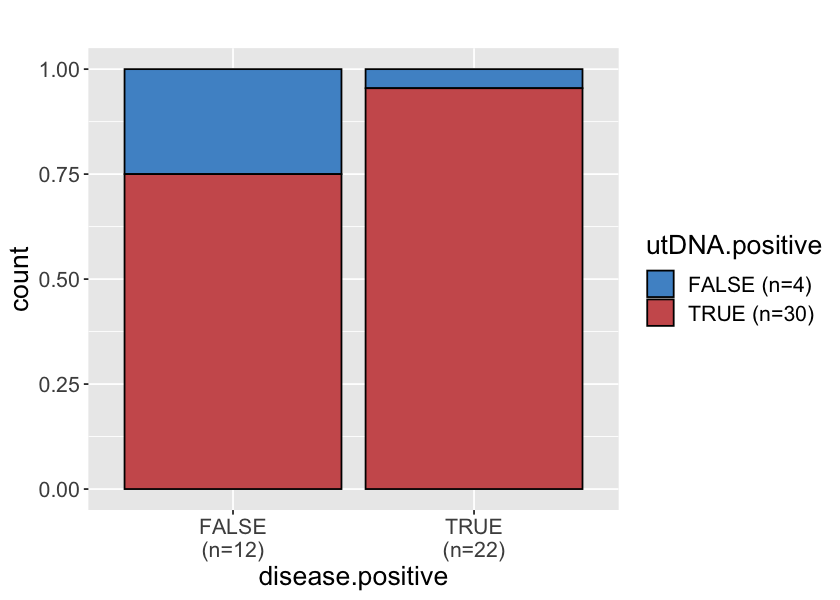

In [223]:
## correlation of mrd.status pipeline call with disease positivity
source("~/Desktop/puffin/R/helper_functions.R")

options(repr.plot.width=7, repr.plot.height=5)

df_plot = df_ngsqc.preur %>% filter(!is.na(disease.positive))

contingency_plot(df = df_plot, x = "disease.positive", y = "utDNA.positive", 
                 y.percent = FALSE, colors = c("FALSE"="steelblue3", "TRUE"="indianred"))

# ggplot(df_plot) +
#   geom_bar(aes(x=factor(disease.positive), fill=factor(mrd.status)), position="fill", color="black") +
#   scale_y_continuous(labels = scales::percent) +
#   scale_fill_manual(name = "utDNA.positive", labels=c("False","True"), values=c("steelblue3", "indianred")) +
#   scale_x_discrete(labels=c("False\n(n=3)","True\n(n=8)")) +
#   labs(y="Percent of Patients", x="disease positive\nat repeat TURBT") +
#   theme(text = element_text(size = 16))

# mat = matrix(c(3,1,5,2), nrow=2, byrow=TRUE)
# print(mat)
# fisher.test(mat)

In [227]:
head(df_plot)
write.csv(df_plot %>% select(-StudyVisit2), "./tissue_probe_mrd/pre_repeat_urine_MRD_all/Batch1n2n3_preRepeatUrine_MRD_data_11072023.csv", row.names=F)

# vars.all1 = read.csv("tissue_probe_mrd/pre_repeat_urine_MRD_all/WOP00253_254_PRDC_MOFFITT_batch1n2/WOP00253_WOP00254_PRDC-MOFFITT-NMIBC-22001_Variant_all_pre_mrd_2022-12-01.csv")
# vars.all2 = read.csv("tissue_probe_mrd/pre_repeat_urine_MRD_all/WOP001172_PRDC_MOFFITT_batch3_pre_urine_mrd/WOP01172_PRDC-MOFFITT-NMIBC-22001_Variant_all_2023-10-18.csv")
# vars.all = rbind.common(vars.all1, vars.all2) %>% mutate(PatientID=fix_PIDs(PatientID)) %>% distinct()
# head(vars.all)
# write.csv(vars.all, "tissue_probe_mrd/pre_repeat_urine_MRD_all/WOP00253_254_1172_PRDC_MOFFITT_preRepeatUrine_MRD_Variant_all_10192023.csv", row.names=F)

,SampleID.sample,SampleID.baseline,mutationCount.baseline.design,mutationCount.baseline,excludeCount,mutationCount,mutationCount.mrd,mutationCount.mrd.f,mrd.score.noNovel,mrd.score,mrd.status,checkDynamic,includeNovel,tf.m.f,tf.f,tf.ext.f,maf,tf.baseline,maf.baseline,tumorfraction.baseline,tumorfraction.baseline.adj,fc.tf.f,fc.tf.m.f,fc.tf.ext.f,tumorFraction.org,tumorFraction,tumorFraction.mrd,SampleID.short.sample,StudyVisit.sample,PatientID,StudyVisit2,PatientID.old.sample,StudyVisit.baseline,PatientID.baseline,PatientID.old.baseline,has.PBMC,wgsTumorfrac_ichorCNA,armAbnormalityScore,fragmentNum,cnbScore,wgsTumorfrac_EM,disease.positive,Repeat.Stage,Index.Stage,Index.CIS,Repeat.CIS,utDNA.positive
,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<lgl>,<lgl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<fct>,<chr>,<chr>,<lgl>,<lgl>,<lgl>
1,P219768,P220082,5,5,73,1,1,1,0.000,0.000,FALSE,TRUE,0,0.000000000,0.000000e+00,0.000000e+00,0.04111842,0.27262814,6.7612,0.28133,0.28133,0.000000e+00,0.001874776,0.000000e+00,0.000000e+00,0.0000500,0.000000e+00,P219768,Pre-RepeatTURBT,173362,NA,173362,IndexTURBT,173362,173362,TRUE,0.0259,60.137,1843520,5.298889,0.0000000,TRUE,TaHG,TaHG,FALSE,FALSE,FALSE
2,P217592,P220085,36,36,0,38,36,36,30.125,31.625,TRUE,TRUE,1,0.022549160,1.627251e-02,1.338526e-02,10.80395545,0.09633794,51.9150,0.68347,0.68347,1.689107e-01,0.234063133,1.389407e-01,9.496180e-02,0.1950100,1.950103e-01,P217592,Pre-RepeatTURBT,173983,NA,173983,IndexTURBT,173983,173983,TRUE,0.0000,55.043,2358302,5.685603,0.0000000,TRUE,>=T2,T1,FALSE,FALSE,TRUE
3,P217594,P220073,34,34,0,34,33,31,16.025,16.025,TRUE,TRUE,0,0.003252546,1.770314e-03,1.336200e-03,0.89898273,0.07938568,23.4690,0.26590,0.26590,2.230017e-02,0.040971448,1.683176e-02,4.475564e-03,0.0178190,1.781946e-02,P217594,Pre-RepeatTURBT,169558,NA,169558,IndexTURBT,169558,169558,TRUE,0.0000,23.266,1936359,3.564916,0.0000000,FALSE,T0,TaLG,FALSE,FALSE,TRUE
4,P219771,P220076,79,78,1,76,73,70,59.800,60.800,TRUE,TRUE,1,0.002797925,2.641349e-03,1.420949e-03,0.54013783,0.20652446,59.8930,0.66059,0.66059,1.278952e-02,0.013547670,6.880296e-03,4.545054e-03,0.0107450,1.074472e-02,P219771,Pre-RepeatTURBT,173334,NA,173334,IndexTURBT,173334,173334,TRUE,0.0000,22.463,2382513,3.521956,0.0000000,TRUE,TaHG,T1,FALSE,FALSE,TRUE
5,P217596,P220079,68,64,4,22,16,6,0.475,0.475,FALSE,TRUE,0,0.000000000,7.060887e-06,7.060887e-06,0.04056795,0.13272485,19.9300,0.34690,0.34690,5.319944e-05,0.001880540,5.319944e-05,1.845488e-05,0.0000500,1.845488e-05,P217596,Pre-RepeatTURBT,172530,NA,172530,IndexTURBT,172530,172530,TRUE,0.0000,16.653,2134340,3.318286,0.0000000,FALSE,T0,T1,FALSE,FALSE,FALSE
6,P217590,P220074,40,21,40,20,7,7,6.125,6.125,TRUE,TRUE,0,0.001755319,1.625665e-03,1.625665e-03,0.45012604,0.26793088,17.6140,0.67709,0.29952,6.067479e-03,0.006551388,6.067479e-03,1.817331e-03,0.0089622,8.962180e-03,P217590,Pre-RepeatTURBT,172851,NA,172851,IndexTURBT,172851,172851,TRUE,0.1427,812.660,2015010,9.686186,0.4306547,TRUE,T1,TaHG,FALSE,FALSE,TRUE


In [229]:
# correlation of MRD tumor fraction with disease positivity and prediction AUCs 
source("~/Desktop/puffin/R/helper_functions.R")

pdf("./tissue_probe_mrd/pre_repeat_urine_MRD_all/NMIBC_ucfDNA_tumorFraction_boxplot_11072023.pdf", onefile = TRUE)

for (stat in c('tf.m.f',
    'tumorFraction',#'mutationCount','mutationCount.mrd','mutationCount.mrd.f',
    'mrd.score'
              )){
    options(repr.plot.width=8, repr.plot.height=5)
    g <- quick_boxplot(df_ngsqc.preur, x="disease.positive",y=stat, colors=c("FALSE"="blue","TRUE"="darkred"), 
                       log.axes = TRUE, log.0.adj=0.00001, plot.title = glue("{stat} by reTUR disease positivity"),
                      #pt.label="PatientID"
                      )
    show(g)
    options(repr.plot.width=7, repr.plot.height=7)
    get_sens_spec(df_ngsqc.preur, "disease.positive", stat, 
                  target_sens=1.0, title=glue("Predict disease.positive using {stat}"))
}
#dev.off()

# correlation of LPWGS with disease positivity and prediction AUCs
for (stat in c('wgsTumorfrac_ichorCNA', 'cnbScore'#, 'wgsTumorfrac_EM'
              )){
    options(repr.plot.width=8, repr.plot.height=5)
    g <- quick_boxplot(df_ngsqc.preur, x="disease.positive",y=stat, colors=c("FALSE"="blue","TRUE"="darkred"), 
                       log.axes = FALSE, plot.title = glue("{stat} by reTUR disease positivity"),
                       #pt.label="PatientID"
                      )
    show(g)
    options(repr.plot.width=7, repr.plot.height=7)
    get_sens_spec(df_ngsqc.preur, "disease.positive", stat, 
                  target_sens=1.0, title=glue("Predict disease positivity by {stat}"))
}
dev.off()

   disease.positive      tf.m.f
1              TRUE 0.000000000
2              TRUE 0.022549160
3             FALSE 0.003252546
4              TRUE 0.002797925
5             FALSE 0.000000000
6              TRUE 0.001755319
7             FALSE 0.000385716
8              TRUE 0.290001477
9              TRUE 0.365575256
10             TRUE 0.313986973
11             TRUE 0.046198467
12            FALSE 0.000000000
13             TRUE 0.027839273
14             TRUE 0.041742364
15             TRUE 0.000515268
16             TRUE 0.099572393
17            FALSE 0.011703498
18             TRUE 0.053634549
19            FALSE 0.018570788
20             TRUE 0.028102064
21            FALSE 0.000000000
22             TRUE 0.185165908
23             TRUE 0.183345585
24            FALSE 0.000599742
25            FALSE 0.000327314
26            FALSE 0.001690557
27             TRUE 0.003569304
28            FALSE 0.000689529
29             TRUE 0.100810796
30             TRUE 0.079660710
31      

Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 4 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_text()`).”


[1] TRUE
[1] TRUE
[1] 34
number of NA labels: 0
[1] "case/control: 22 / 12"


Setting levels: control = FALSE, case = TRUE



   threshold specificity sensitivity
1 0.02055997           1   0.6818182
[1] "target sens 1"
  threshold specificity sensitivity
1      -Inf           0           1
[1] "AUC: 0.857954545454546"
   disease.positive tumorFraction
1              TRUE    0.00005000
2              TRUE    0.19501000
3             FALSE    0.01781900
4              TRUE    0.01074500
5             FALSE    0.00005000
6              TRUE    0.00896220
7             FALSE    0.00033253
8              TRUE    0.53540000
9              TRUE    0.83861000
10             TRUE    0.66418000
11             TRUE    0.18082000
12            FALSE    0.00005000
13             TRUE    0.08157200
14             TRUE    0.53142000
15             TRUE    0.16245000
16             TRUE    0.25716000
17            FALSE    0.03596200
18             TRUE    0.20326000
19            FALSE    0.06349200
20             TRUE    0.10363000
21            FALSE    0.00005000
22             TRUE    0.38869000
23             TRUE    

Warning message:
“Removed 1 rows containing missing values (`geom_text()`).”


[1] TRUE
[1] TRUE
[1] 34
number of NA labels: 0
[1] "case/control: 22 / 12"


Setting levels: control = FALSE, case = TRUE



  threshold specificity sensitivity
1  0.072532           1   0.7272727
[1] "target sens 1"
  threshold specificity sensitivity
1      -Inf           0           1
[1] "AUC: 0.873106060606061"
   disease.positive mrd.score
1              TRUE    0.0000
2              TRUE   31.6250
3             FALSE   16.0250
4              TRUE   60.8000
5             FALSE    0.4750
6              TRUE    6.1250
7             FALSE    9.6000
8              TRUE   38.8750
9              TRUE    8.3750
10             TRUE   56.2500
11             TRUE   39.3250
12            FALSE    2.6500
13             TRUE    4.8000
14             TRUE   40.7500
15             TRUE    2.8250
16             TRUE   25.7750
17            FALSE   50.3250
18             TRUE   35.0250
19            FALSE   20.7810
20             TRUE   26.9250
21            FALSE    1.0250
22             TRUE    2.8000
23             TRUE   29.1250
24            FALSE   13.4500
25            FALSE    2.1500
26            FALSE   15.20

Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 1 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_text()`).”


[1] TRUE
[1] TRUE
[1] 34
number of NA labels: 0
[1] "case/control: 22 / 12"


Setting levels: control = FALSE, case = TRUE



  threshold specificity sensitivity
1   23.4815   0.9166667   0.5454545
[1] "target sens 1"
  threshold specificity sensitivity
1      -Inf           0           1
[1] "AUC: 0.68560606060606"
   disease.positive wgsTumorfrac_ichorCNA
1              TRUE                0.0259
2              TRUE                0.0000
3             FALSE                0.0000
4              TRUE                0.0000
5             FALSE                0.0000
6              TRUE                0.1427
7             FALSE                0.0000
8              TRUE                0.1260
9              TRUE                0.3565
10             TRUE                0.1826
11             TRUE                0.0259
12            FALSE                0.0000
13             TRUE                    NA
14             TRUE                0.0266
15             TRUE                0.2441
16             TRUE                0.0354
17            FALSE                0.0000
18             TRUE                0.0265
19        

Warning message:
“Removed 1 rows containing missing values (`geom_text()`).”


[1] TRUE
[1] TRUE
[1] 32
number of NA labels: 0
[1] "case/control: 22 / 12"


Setting levels: control = FALSE, case = TRUE



  threshold specificity sensitivity
1    0.0218           1        0.85
[1] "target sens 1"
  threshold specificity sensitivity
1      -Inf           0           1
[1] "AUC: 0.9125"
   disease.positive  cnbScore
1              TRUE  5.298889
2              TRUE  5.685603
3             FALSE  3.564916
4              TRUE  3.521956
5             FALSE  3.318286
6              TRUE  9.686186
7             FALSE  4.023014
8              TRUE  9.327906
9              TRUE  9.927298
10             TRUE  9.270623
11             TRUE  6.529883
12            FALSE  4.578703
13             TRUE        NA
14             TRUE  6.694965
15             TRUE 10.356708
16             TRUE  7.482852
17            FALSE  5.257362
18             TRUE  7.336440
19            FALSE  5.928365
20             TRUE  5.796174
21            FALSE  5.655735
22             TRUE 10.622267
23             TRUE  8.836156
24            FALSE  3.727785
25            FALSE  3.885706
26            FALSE  3.233484
27      

Warning message:
“Removed 1 rows containing missing values (`geom_text()`).”


[1] TRUE
[1] TRUE
[1] 32
number of NA labels: 0
[1] "case/control: 22 / 12"


Setting levels: control = FALSE, case = TRUE



  threshold specificity sensitivity
1  5.670669   0.9166667        0.85
[1] "target sens 1"
  threshold specificity sensitivity
1  3.447388        0.25           1
[1] "AUC: 0.9125"


pdf 
  2

In [233]:
## AUA stats for 34 patients
median(df_ngsqc.preur$wgsTumorfrac_ichorCNA[df_ngsqc.preur$disease.positive=="TRUE"], na.rm=T)
median(df_ngsqc.preur$wgsTumorfrac_ichorCNA[df_ngsqc.preur$disease.positive=="FALSE"], na.rm=T)

median(df_ngsqc.preur$tumorFraction[df_ngsqc.preur$disease.positive=="TRUE"], na.rm=T)
median(df_ngsqc.preur$tumorFraction[df_ngsqc.preur$disease.positive=="FALSE"], na.rm=T)

[1] 0.0375

[1] 0

[1] 0.199135

[1] 0.00041432

In [243]:
pdf("./tissue_probe_mrd/pre_repeat_urine_MRD_all/NMIBC_PreRepeatUrine_LPvsPanel_scatter_11072023.pdf", 
    width=9,height=7, onefile=TRUE)

#pat.colors = get_random_color_dict(df_ngsqc.urine.mrd$PatientID)

# 3 patients LPWGS Fail

scaleFUN <- function(x) sprintf("%.5f", x)
options(repr.plot.width=10, repr.plot.height=8)
ggplot(df_ngsqc.preur, aes(x=cnbScore, y=tumorFraction, color=disease.positive, shape=has.PBMC)) + 
    geom_point(size=4) + 
    scale_y_continuous(trans='log2', labels=scaleFUN) +
    scale_color_manual(values = c("TRUE"="indianred", "FALSE"="steelblue")) +
    #scale_x_discrete(labels=c("TRUE \nN=20", "FALSE\nN=12")) +
    theme(text=element_text(size=16)) +
    ylab("Panel tumorFraction")

ggplot(df_ngsqc.preur, aes(x=cnbScore, y=tumorFraction, color=disease.positive, label=PatientID
                              )) + 
    #geom_point(size=4) + 
    scale_y_continuous(trans='log2', labels=scaleFUN) +
    scale_color_manual(values = c("TRUE"="indianred", "FALSE"="steelblue")) +
    geom_text(check_overlap = FALSE, position=position_jitter(),size=5) +
    #scale_color_manual(values=pat.colors) +
    theme(text=element_text(size=16)) +
    ylab("Panel tumorFraction")
dev.off()

Warning message:
“Removed 2 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 2 rows containing missing values (`geom_text()`).”


pdf 
  2

In [76]:
names(df_samples_all)

[1] "Order_orig"          "Order_pt"            "Sample.ID"          
 [4] "Patient.ID_new"      "Visit_new"           "Sample.Type"        
 [7] "Cancer.stage"        "Collection.Date_new" "Batch."             
[10] "Receive.Date"        "PredicineID"         "EX...QC"            
[13] "EPIC"                "MRD"                 "WES."               
[16] "MRDprobe"            "SampleID.short"      "PatientID"          
[19] "StudyVisit2"         "StudyVisit"          "SampleType"         
[22] "SampleID"

# Methylation for preRepeat MRD 

In [244]:
df_ngsqc.preur = read.csv("./tissue_probe_mrd/tmp_mrd_data_set.csv")
head(df_ngsqc.preur)

df_lpwgs_all = read.csv("./tissue_probe_mrd/LPWGS_data_all_11062023.csv")
head(df_lpwgs_all)

,SampleID.sample,SampleID.baseline,mutationCount.baseline.design,mutationCount.baseline,excludeCount,mutationCount,mutationCount.mrd,mutationCount.mrd.f,mrd.score.noNovel,mrd.score,mrd.status,checkDynamic,includeNovel,tf.m.f,tf.f,tf.ext.f,maf,tf.baseline,maf.baseline,tumorfraction.baseline,tumorfraction.baseline.adj,fc.tf.f,fc.tf.m.f,fc.tf.ext.f,tumorFraction.org,tumorFraction,tumorFraction.mrd,SampleID.short.sample,StudyVisit.sample,PatientID,StudyVisit2,PatientID.old.sample,StudyVisit.baseline,PatientID.baseline,PatientID.old.baseline,has.PBMC,wgsTumorfrac_ichorCNA,armAbnormalityScore,fragmentNum,cnbScore,wgsTumorfrac_EM
,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<lgl>,<lgl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<int>,<lgl>,<int>,<chr>,<int>,<int>,<lgl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>
1,P219768,P220082,5,5,73,1,1,1,0.000,0.000,FALSE,TRUE,0,0.0005111168,0.000000e+00,0.000000e+00,0.04111842,0.27262814,6.7612,0.28133,0.28133,0.000000e+00,0.001874776,0.000000e+00,0.000000e+00,0.0000e+00,0.000000e+00,P219768,Pre-RepeatTURBT,173362,NA,173362,IndexTURBT,173362,173362,TRUE,0.0259,60.137,1843520,5.298889,0.0000000
2,P217592,P220085,36,36,0,38,36,36,30.125,31.625,TRUE,TRUE,1,0.0225491599,1.627251e-02,1.338526e-02,10.80395545,0.09633794,51.9150,0.68347,0.68347,1.689107e-01,0.234063133,1.389407e-01,9.496180e-02,1.9501e-01,1.950103e-01,P217592,Pre-RepeatTURBT,173983,NA,173983,IndexTURBT,173983,173983,TRUE,0.0000,55.043,2358302,5.685603,0.0000000
3,P217594,P220073,34,34,0,34,33,31,16.025,16.025,TRUE,TRUE,0,0.0032525463,1.770314e-03,1.336200e-03,0.89898273,0.07938568,23.4690,0.26590,0.26590,2.230017e-02,0.040971448,1.683176e-02,4.475564e-03,1.7819e-02,1.781946e-02,P217594,Pre-RepeatTURBT,169558,NA,169558,IndexTURBT,169558,169558,TRUE,0.0000,23.266,1936359,3.564916,0.0000000
4,P219771,P220076,79,78,1,76,73,70,59.800,60.800,TRUE,TRUE,1,0.0027979252,2.641349e-03,1.420949e-03,0.54013783,0.20652446,59.8930,0.66059,0.66059,1.278952e-02,0.013547670,6.880296e-03,4.545054e-03,1.0745e-02,1.074472e-02,P219771,Pre-RepeatTURBT,173334,NA,173334,IndexTURBT,173334,173334,TRUE,0.0000,22.463,2382513,3.521956,0.0000000
5,P217596,P220079,68,64,4,22,16,6,0.475,0.475,FALSE,TRUE,0,0.0002495944,7.060887e-06,7.060887e-06,0.04056795,0.13272485,19.9300,0.34690,0.34690,5.319944e-05,0.001880540,5.319944e-05,1.845488e-05,1.8455e-05,1.845488e-05,P217596,Pre-RepeatTURBT,172530,NA,172530,IndexTURBT,172530,172530,TRUE,0.0000,16.653,2134340,3.318286,0.0000000
6,P217590,P220074,40,21,40,20,7,7,6.125,6.125,TRUE,TRUE,0,0.0017553191,1.625665e-03,1.625665e-03,0.45012604,0.26793088,17.6140,0.67709,0.29952,6.067479e-03,0.006551388,6.067479e-03,1.817331e-03,8.9622e-03,8.962180e-03,P217590,Pre-RepeatTURBT,172851,NA,172851,IndexTURBT,172851,172851,TRUE,0.1427,812.660,2015010,9.686186,0.4306547


,SampleID,Total.reads..M.,Mapped.reads..M.,Mapping.rate....,Consensus.reads..M.,Duplication.rate....,Fragment_Size_Mode,Softclip.ratio,ProjectDir,coveredGenomicPect,coverage,qcLabel,gender,wgsTumorfrac_ichorCNA,armAbnormalityScore,fragmentNum,cnbScore,classificationLabel,binNum,cnvbinNum,cnabinNum,cnlbinNum,cnvbinRatio,neutbinNum,neutbinRatio,wgsTumorfrac_EM,externalSampleID,SampleID.short,SampleType,StudyVisit,PatientID,disease.positive
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<int>,<dbl>,<chr>,<int>,<int>,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<int>,<lgl>
1,P220068_WGS,1190,1180,99.5,647,45.2,157,0.985,/prednet/data23/OutputByRun23/TM_lpwgsRerun/WGS_WOP00249_WOP00250_PRDC-MOFFITT-NMIBC/bamfiles_pbmcBaseline,95.1,26.84,Pass,female,0.1273,992.271,26924036,10.046665,highRisk,2442,1321,838,483,0.541,412,0.169,0.3592600,06S22068061,P220068,Tissue,IndexTURBT,172229,TRUE
2,P220069_WGS,1210,1200,99.7,623,48.2,147,0.530,/prednet/data23/OutputByRun23/TM_lpwgsRerun/WGS_WOP00249_WOP00250_PRDC-MOFFITT-NMIBC/bamfiles_pbmcBaseline,95.4,24.92,Pass,male,0.3867,1884.494,26393139,11.002190,highRisk,2441,1330,430,900,0.545,1078,0.442,0.4733614,06S22035975,P220069,Tissue,IndexTURBT,172586,TRUE
3,P220070_WGS,1200,1190,99.7,650,45.5,180,0.366,/prednet/data23/OutputByRun23/TM_lpwgsRerun/WGS_WOP00249_WOP00250_PRDC-MOFFITT-NMIBC/bamfiles_pbmcBaseline,95.4,31.19,Pass,male,0.2390,1258.305,31753729,10.415608,highRisk,2442,1321,599,722,0.541,1062,0.435,0.2534166,06S22052895,P220070,Tissue,RepeatTURBT,172586,TRUE
4,P220073_WGS,973,970,99.6,538,44.5,179,0.429,/prednet/data23/OutputByRun23/TM_lpwgsRerun/WGS_WOP00249_WOP00250_PRDC-MOFFITT-NMIBC/bamfiles_pbmcBaseline,95.4,26.80,Pass,male,0.0242,163.316,27302368,7.340233,highRisk,2442,242,92,150,0.099,318,0.130,0.1063838,06S22052894,P220073,Tissue,IndexTURBT,169558,FALSE
5,P220074_WGS,1260,1260,99.7,662,47.4,179,0.408,/prednet/data23/OutputByRun23/TM_lpwgsRerun/WGS_WOP00249_WOP00250_PRDC-MOFFITT-NMIBC/bamfiles_pbmcBaseline,95.4,32.62,Pass,male,0.1193,983.514,33927666,9.880656,highRisk,2442,1405,783,622,0.575,488,0.200,0.2080755,06S22036104,P220074,Tissue,IndexTURBT,172851,TRUE
6,P220075_WGS,1140,1130,99.7,630,44.3,183,0.633,/prednet/data23/OutputByRun23/TM_lpwgsRerun/WGS_WOP00249_WOP00250_PRDC-MOFFITT-NMIBC/bamfiles_pbmcBaseline,95.4,30.20,Pass,male,0.1407,1200.872,30989435,10.299508,highRisk,2442,1675,814,861,0.686,568,0.233,0.2215777,06S22052897,P220075,Tissue,RepeatTURBT,172851,TRUE


In [332]:
## methyl data

# old methyl data for pre- and post- op urine samples from batch 1+2
# methyl.data1n2 = standardize_names(read_excel("./Methylation_data/batch1n2/region_summary_info_batch1n2.xlsx", sheet="in") %>%
#                                                 mutate(SampleID = Sample.Name)  %>% slice_head(n=44),
#                                    sid.format = "remove.suffix", input.type="samples") %>%
#                 select(-SampleType) %>%
#                 left_join(df_samples_all %>% select(SampleID.short, SampleType), by="SampleID.short")
# #warn_na(methyl.data1n2$SampleType)
#table(methyl.data1n2$SampleType, methyl.data1n2$StudyVisit)
methyl.data = read.csv("./Methylation_data/Nov_6_2023/PRDC-MOFFITT-NMIBC-22001_165_samples_Methylation_summary_info_11082023.csv") # missing batch 3 and 4 urine samples
methyl.data = standardize_names(methyl.data %>% mutate(SampleID=Sample.Name) %>% slice_head(n=165),
                                sid.format = "remove.suffix", input.type="samples") %>%
                select(-SampleType) %>%
                mutate(PatientID=fix_PIDs(SubjectID)) %>%
                left_join(df_samples_all %>% select(SampleID.short, SampleType), by="SampleID.short")
names(methyl.data)
write.csv(methyl.data, "./Methylation_data/Nov_6_2023/region_summary_for_client_formatted.csv", row.names=F)
stop()

#warn_na(methyl.data3n4$SampleType)
#table(methyl.data3n4$SampleType, methyl.data1n2$StudyVisit)
# methyl.data = rbind.common(methyl.data1n2, methyl.data3n4) %>%
#                     mutate(PatientID = fix_PIDs(SubjectID))

methyl.data = methyl.data %>% left_join(df_clin %>% select(PatientID, disease.positive), by="PatientID") %>%
                    mutate(SampleType=ifelse(is.na(SampleType), "Tissue", SampleType), # missing sampletype for benign urotheils
                           disease.positive = factor(disease.positive, levels=c("FALSE","TRUE")))

table(methyl.data$StudyVisit, methyl.data$SampleType)
#head(methyl.data)
#write.csv(methyl.data, "./Methylation_data/all_methyl_data_NMIBC_11062023.csv", row.names=F)

methyl.data.preur = methyl.data %>% filter(StudyVisit=="Pre-Repeat TURBT", 
                                           SampleType == "Urine",
                                           #PatientID %in% pre.urine.mrd.patients # add batch 4 patients
                                          )
table(methyl.data.preur$PatientID)

for (stat in c("filtered_total_abnormal_regions_per_sample",
               "filtered_total_abnormal_frags_per_sample")){
    
    options(repr.plot.width=8, repr.plot.height=5)
    g <- quick_boxplot(methyl.data.preur, x="disease.positive",y=stat, colors=c("FALSE"="blue","TRUE"="darkred"), 
                       log.axes = TRUE, plot.title = glue("{stat} by reTUR disease positivity"))
    show(g)
    
    options(repr.plot.width=7, repr.plot.height=7)
    get_sens_spec(methyl.data.preur, "disease.positive", stat, 
                  target_sens=1.0, title=glue("Predict disease positivity by {stat}"))
    }
    
    
#     scaleFUN <- function(x) sprintf("%.0f", x)
#     gg <- ggplot(df_ngsqc.urine.mrd_, aes_string(x="tumorFraction", y=stat, color="disease.positive")) +
#                 geom_point(size=8,alpha=0.5) +
#                 scale_color_manual(values=c("FALSE"="blue","TRUE"="darkred")) +
#                 scale_y_continuous(trans='log2', labels=scaleFUN) + 
#                 theme(text = element_text(size=16))
#     show(gg)
#     gg <- ggplot(df_ngsqc.urine.mrd_, aes_string(x="cnbScore", y=stat, color="disease.positive")) +
#                 geom_point(size=8,alpha=0.5) +
#                 scale_color_manual(values=c("FALSE"="blue","TRUE"="darkred")) +
#                 #scale_y_continuous(trans='log2', labels=scaleFUN) + 
#                 theme(text = element_text(size=16))
#     show(gg)
#}

###
# df_ngsqc.preur = df_ngsqc.preur %>% left_join(methyl.data %>% select(-StudyVisit,-SubjectID,-ExternalID),
#                                                        by="SampleID.short")

## does methyl in preUR predict disease

SampleID.short format: remove.suffix


Standardize.names WARN:Fill all with NA for SampleType



 [1] "116381" "152237" "161922" "165028" "167162" "169558" "171374" "171769"
 [9] "171821" "172153" "172229" "172530" "172586" "172602" "172749" "172851"
[17] "173281" "173334" "173350" "173362" "173509" "173912" "173975" "173983"
[25] "174083" "174091" "174872" "174947" "175325" "175387" "175425" "175492"
[33] "175526" "175610" "175648" "175672" "175725" "175733" "175854" "175980"
[41] "176349" "176388" "176828" "176992" "177967" "178886" "180264" "182022"
[49] "173359"


[1] "SubjectID"                                 
 [2] "StudyVisit"                                
 [3] "ExternalID"                                
 [4] "Sample.Name"                               
 [5] "total_abnormal_regions_per_sample"         
 [6] "total_abnormal_frags_per_sample"           
 [7] "filtered_total_abnormal_regions_per_sample"
 [8] "filtered_total_abnormal_frags_per_sample"  
 [9] "SampleID"                                  
[10] "SampleID.short"                            
[11] "PatientID"                                 
[12] "SampleType"

ERROR: Error in eval(expr, envir, enclos): 


[1] 49

warn_na: WARN: NA or missing values in Index.Tissue: 8

warn_na: WARN: NA or missing values in Repeat.Tissue: 21

warn_na: WARN: NA or missing values in Plasma: 34

warn_na: WARN: NA or missing values in Urine Cell Pellet: 34

warn_na: WARN: NA or missing values in Urine: 34

warn_na: WARN: NA or missing values in Index.Tissue: 8

warn_na: WARN: NA or missing values in Repeat.Tissue: 21

warn_na: WARN: NA or missing values in Plasma: 34

warn_na: WARN: NA or missing values in Urine Cell Pellet: 34

warn_na: WARN: NA or missing values in Urine: 34

warn_na: WARN: NA or missing values in Index.Tissue: 8

warn_na: WARN: NA or missing values in Repeat.Tissue: 21

warn_na: WARN: NA or missing values in Plasma: 34

warn_na: WARN: NA or missing values in Urine Cell Pellet: 34

warn_na: WARN: NA or missing values in Urine: 34



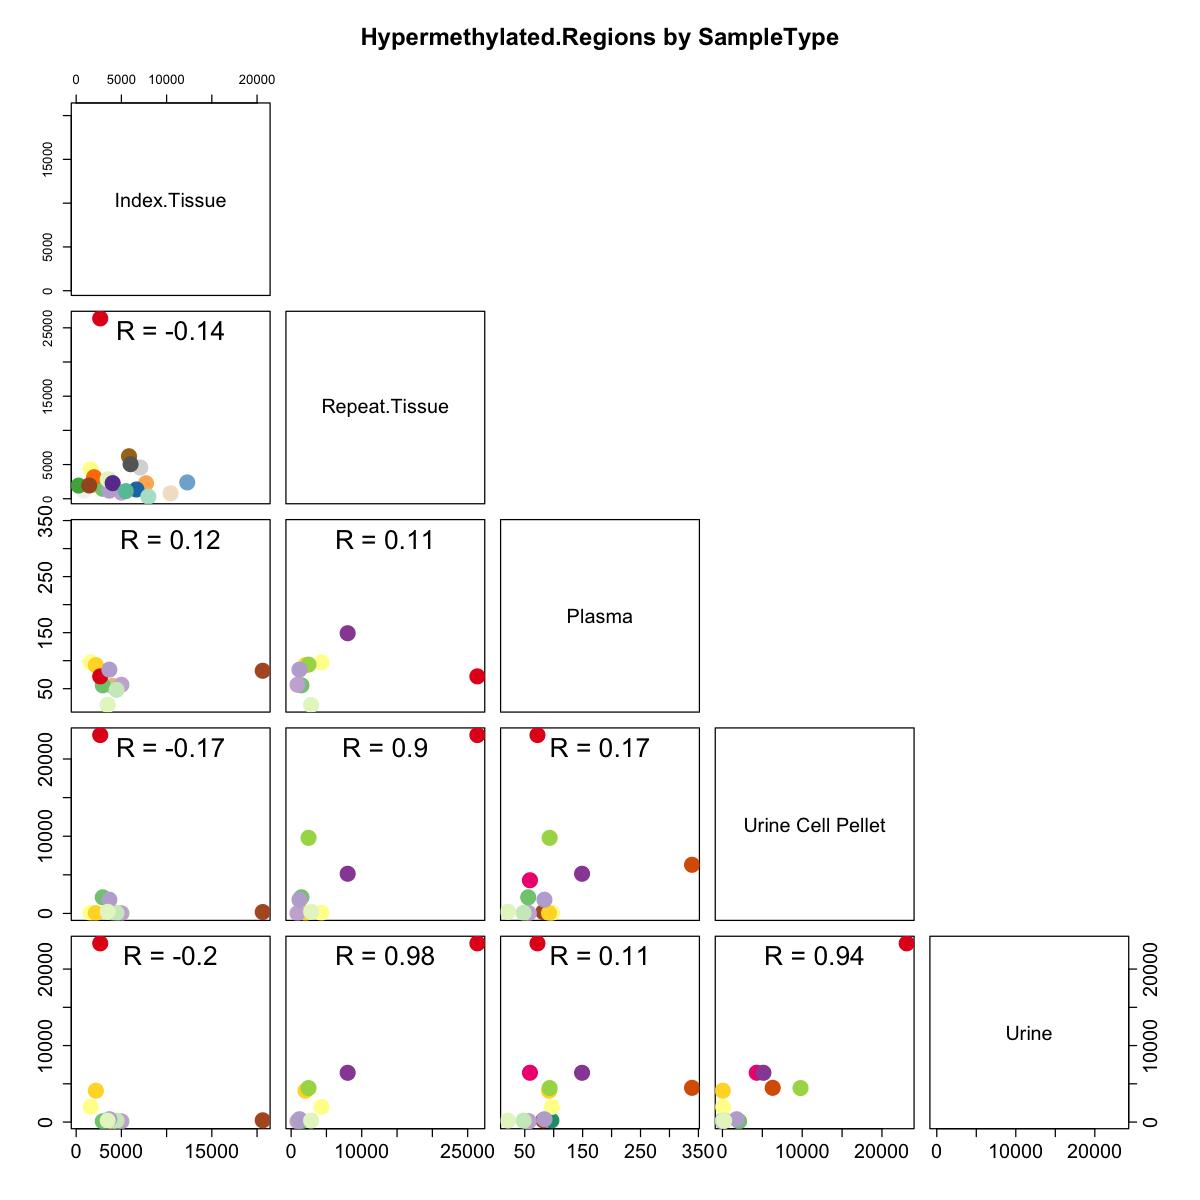


 Index.Tissue        Plasma Repeat.Tissue         Urine          <NA> 
           41            15            28            15             0 

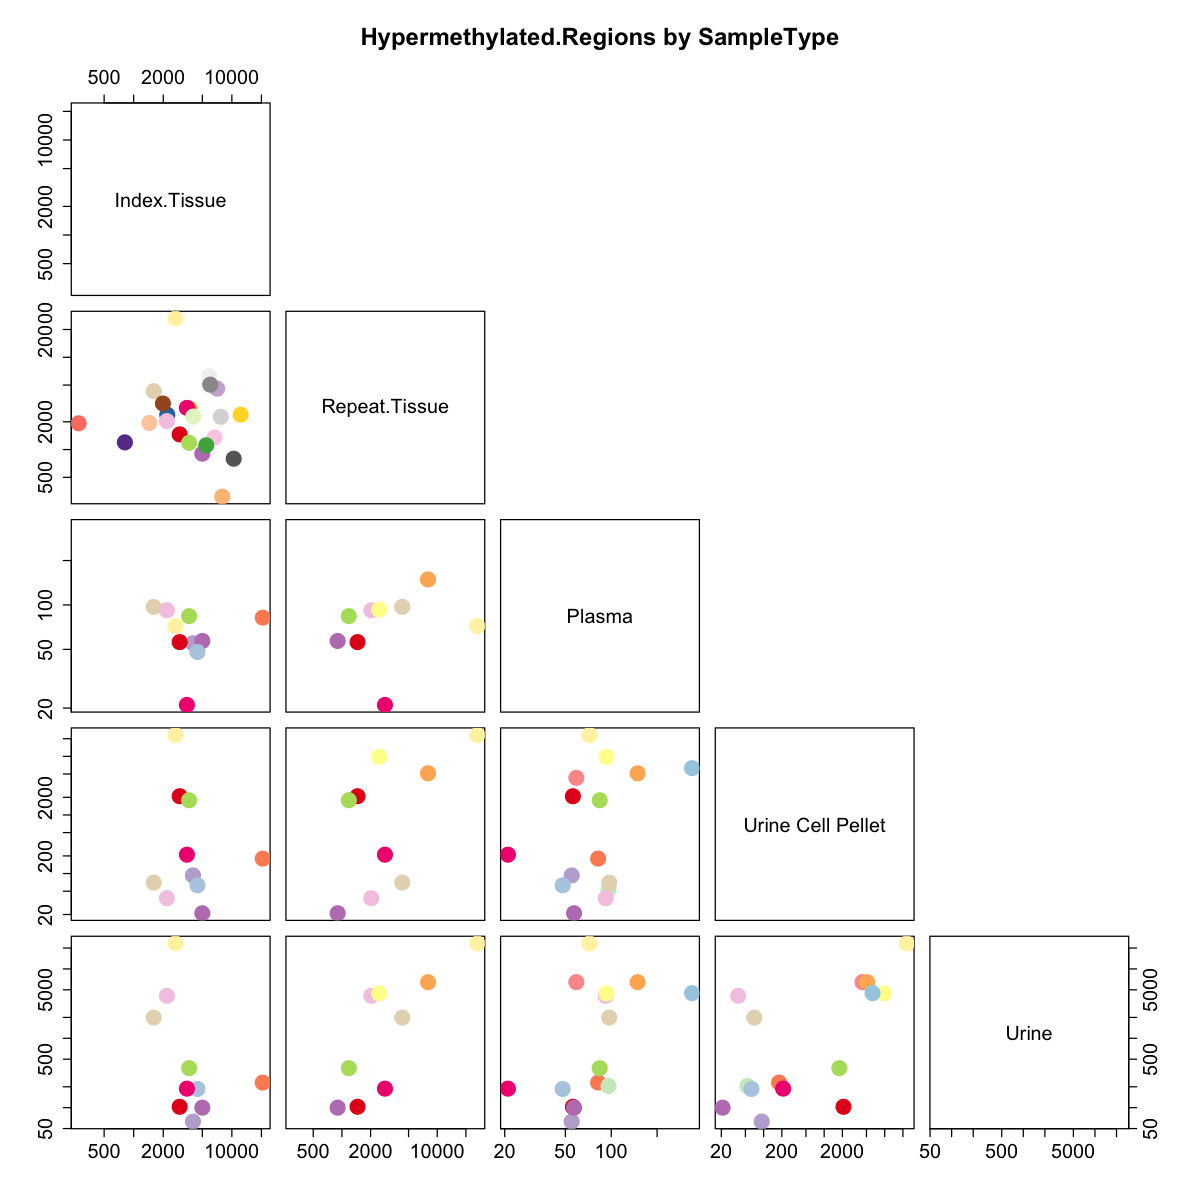

In [330]:
source("~/Desktop/puffin/R/plotFunctions.R")
# pairs plots
# is methyl in index or repeat correlated with preUR
# how does PBMC data help us?
# corr urine vs plasma vs. ucp vs. tissue
# benign vs cancer patterns?
# methyl vs lpwgs?
df_plot = methyl.data %>% 
            filter(StudyVisit %in% c("IndexTURBT","RepeatTURBT","Pre-Repeat TURBT"),
                  SampleType %in% c("Tissue","Urine","Plasma", "Urine Cell Pellet")) %>%
            mutate(SampleType=ifelse(StudyVisit=="IndexTURBT", "Index.Tissue",
                                        ifelse(StudyVisit=="RepeatTURBT", "Repeat.Tissue", SampleType))) %>%
            rename("Hypermethylated.Regions"="filtered_total_abnormal_regions_per_sample") %>% 
            select(PatientID, StudyVisit, Hypermethylated.Regions, SampleType) %>%
            pivot_wider(id_cols = "PatientID", names_from = "SampleType", names_sep = ".",values_from = "Hypermethylated.Regions")
nrow(df_plot) #49 patients
warn_na(df_plot)
options(repr.plot.width=10, repr.plot.height=10)
plt <- pairs_(df_plot, cols = names(df_plot), 
              color.by = "PatientID", log.scale=FALSE,
              legend = FALSE, plot.title="Hypermethylated.Regions by SampleType")
plt <- pairs_(df_plot, cols = names(df_plot), 
              color.by = "PatientID", log.scale=TRUE,
              legend = FALSE, plot.title="Hypermethylated.Regions by SampleType")

df_count = methyl.data %>% 
            filter(StudyVisit %in% c("IndexTURBT","RepeatTURBT","Pre-Repeat TURBT"),
                  SampleType %in% c("Tissue","Urine","Plasma")) %>%
            mutate(SampleType=ifelse(StudyVisit=="IndexTURBT", "Index.Tissue",
                                        ifelse(StudyVisit=="RepeatTURBT", "Repeat.Tissue", SampleType))) %>%
            rename("Hypermethylated.Regions"="filtered_total_abnormal_regions_per_sample") %>% 
            select(PatientID, StudyVisit, Hypermethylated.Regions, SampleType)
     
table(df_count$SampleType)

,subject_id,study_visit,external_ID,requisition_ID,chr,start,end,width,mean_fragment_beta,abnormal_fragments,log10_p.value,gene_symbol,annotation_type,CGI_overlap,CpG_num,TSS_dist,nearest_transcript,transcript_overlap
,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<dbl>,<int>,<int>,<chr>,<chr>,<lgl>,<int>,<int>,<chr>,<lgl>
1,116381,IndexTURBT,06S23005718,P228837_M,chr1,975335,975586,251,0.74,6,18,AGRN,hg19_genes_introns,TRUE,15,19833,uc001ack.2,TRUE
2,116381,IndexTURBT,06S23005718,P228837_M,chr1,975586,975837,251,0.88,5,15,AGRN,hg19_genes_introns,TRUE,19,20084,uc001ack.2,TRUE
3,116381,IndexTURBT,06S23005718,P228837_M,chr1,1474938,1475189,251,0.72,3,9,TMEM240,hg19_genes_exons,TRUE,27,551,uc009vkf.3,TRUE
4,116381,IndexTURBT,06S23005718,P228837_M,chr1,6268983,6269234,251,0.72,4,12,RNF207,hg19_genes_5UTRs,TRUE,31,2795,uc001amg.3,TRUE
5,116381,IndexTURBT,06S23005718,P228837_M,chr1,9065203,9065454,251,0.70,4,12,SLC2A7,hg19_genes_introns,FALSE,9,20950,uc009vmo.1,TRUE
6,116381,IndexTURBT,06S23005718,P228837_M,chr1,18956101,18956352,251,0.77,4,12,PAX7,hg19_genes_1to5kb,FALSE,13,1148,uc001bay.3,FALSE



              hg19_genes_1to5kb                hg19_genes_5UTRs 
                          80882                           22428 
               hg19_genes_exons           hg19_genes_intergenic 
                          63396                          100334 
hg19_genes_intronexonboundaries              hg19_genes_introns 
                            189                           97772 
           hg19_genes_promoters                            <NA> 
                         104339                               0 

SampleID.short format: remove.suffix


[1] 4

[1] "Index.Tissue"  "Repeat.Tissue" "Urine"         "Plasma"

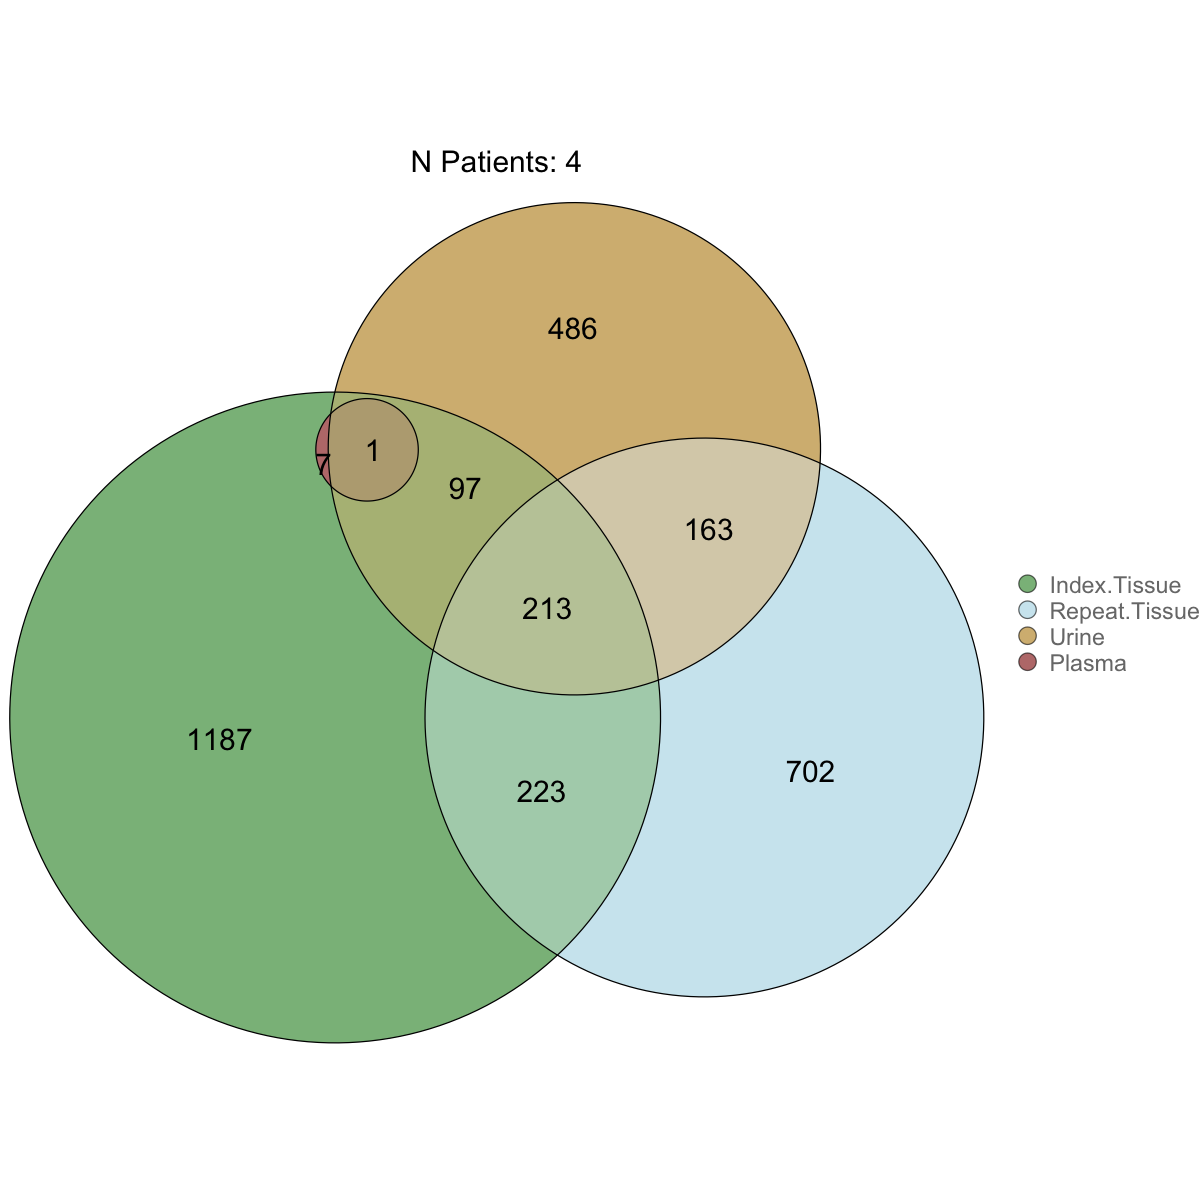

In [297]:
source("~/Desktop/puffin/R/get_concordance_stats.R")

methyl.regions = read.csv("./Methylation_data/Nov_6_2023/test_sample_abnormal_regions_11062023.csv")
head(methyl.regions)
table(methyl.regions$annotation_type)


methyl.promoters = methyl.regions %>% filter(requisition_ID %in% methyl.data$SampleID,
                                             annotation_type == "hg19_genes_promoters",
                                            !is.na(gene_symbol)) %>%
                        mutate(label=paste(subject_id, gene_symbol, sep=":"),
                               SampleID.short = make_SIDshort(requisition_ID, "remove.suffix")) %>% 
                        left_join(df_samples_all %>% select(SampleID.short, SampleType), by="SampleID.short") %>%
                        filter(study_visit %in% c("IndexTURBT","RepeatTURBT","Pre-Repeat TURBT"),
                              SampleType %!in% c(#"Plasma", 
                                                  "Buffycoat", "Urine Cell Pellet"
                                                )) %>%
                        mutate(SampleType=ifelse(study_visit=="IndexTURBT", "Index.Tissue",
                                        ifelse(study_visit=="RepeatTURBT", "Repeat.Tissue", SampleType)))
samples = methyl.promoters %>% group_by(subject_id) %>% mutate(n_samples=length(unique(SampleType))) %>%
            filter(n_samples >= 4)
methyl.promoters = methyl.promoters %>% filter(subject_id %in% samples$subject_id)

warn_na(methyl.promoters$SampleType)
warn_na(methyl.promoters$study_visit)
n.patients = length(unique(samples$subject_id))
n.patients

plot_list = list()
for (st in unique(methyl.promoters$SampleType)){
    plot_list[[st]] = unique(methyl.promoters %>% filter(SampleType==st) %>% pull(label))
}
names(plot_list)
v <- euler(plot_list) # function converts list to alphabetical order by label
  eulerr_options(padding = unit(5, "mm"))
  plot(v, quantities = list(type = "counts", cex=1.5),
          fills = list(fill = c("forestgreen","lightblue","darkgoldenrod","darkred"), alpha=0.6),
          legend = list(plot=TRUE, fontsize = 14),
          main=glue("N Patients: {n.patients}"))

In [321]:
genes = plot_list[["Urine"]][plot_list[["Urine"]] %in% plot_list[["Repeat.Tissue"]][plot_list[["Repeat.Tissue"]] %in% plot_list[["Index.Tissue"]]]]
length(genes)
#sort(genes)
table(methyl.promoters$subject_id)

genes = unlist(lapply(genes, function(x) str_split(x,":")))
genes = sort(genes[genes %!in% unique(methyl.promoters$subject_id)])
matrix(c(unique(genes), rep("",6)), ncol=10)
                      
table(methyl.)

[1] 215


171769 172229 173334 173509   <NA> 
  1662   1732   1190    971      0 

AARD,BCL2L11,CRISPLD1,GOLPH3L,IFT80,MEGF11,OTX1,PROCA1,SMTN,VOPP1
ACAT2,BCL6,CRYBG1,GPR78,IQUB,MERTK,OXCT2,PROSER3,SNX32,WDR87BP
ACIN1,BDNF,DBNDD2,GPX3,KAT7,MGA,PABPC1L,PUM2,SOX2,WNT3
ACTRT3,BOLL,DGKI,GSK3A,KCNIP2,MIR196A2,PAX6,RAB12,SP9,ZNF135
ADAMTSL1,C17orf107,DLX6-AS1,H2BC9,KLF11,MKNK2,PCDHGB5,RAB31,SPACA6,ZNF154
ADGRD2,CA3,DMRTA2,H3C12,KLF4,MLH1,PCDHGB6,RASSF1,SPAG6,ZNF418
ADHFE1,CALB1,DYNLT2B,H4C6,KLHDC9,MLX,PCDHGC4,RBP1,SPATA20,ZNF667-AS1
AFAP1L2,CCDC106,EHBP1-AS1,HLF,LAMB1,MSC,PENK,REC8,TBX15,ZNF701
AKR1E2,CCDC13,EPHB4,HOXA11,LBX2,MSC-AS1,PER1,RGS22,TBX4,ZNF709
ALX1,CD93,EPHX3,HOXB-AS1,LEPR,MT1A,PFKFB4,RHBDL1,TCF7,ZNF813
AMIGO3,CDKN2A-DT,EPS8L1,HOXB5,LINC00526,MTMR7,PHF11,RSPH6A,TJP2,ZNF814


In [6]:
## sumarize urine beacon # rerun
## number of baseline probes, # number of probes conf. detected 
    # mrd score # number new mutations detected #urine tumorFraction without new muts ## tumroFrac with new muts.
#select("PatientID","SampleID","SampleType","StudyVisit","has.IndexTURBT","has.repeatTURBT",
#                                "IndexPTStage","Repeat.Stage","disease.positive","utDNA.positive","tumorFraction_0")
mrd.table = df_mrd_pre %>% rename("N.baseline.muts.detected.mrdInfo"=mutationCount,
                                  "N.personal.probes.detected.mrdInfo"=mutationCount.mrd,
                                  "N.probes.detected.dynamic.mrdInfo"=mutationCount.mrd.f,
                                  "MRD.score"=mrd.score,
                                  "MRD.call"=mrd.status,
                                  "TF.all.muts.mrdInfo"=tumorfraction.baseline,
                                  "TF.dynamic.muts.mrdInfo"=tumorfraction.baseline.adj,
                                  "TF.dynamic.highqual.muts.mrdInfo"=tumorFraction) %>% 
               select(SampleID.short, PatientID, SampleType, StudyVisit, 
                      #"N.baseline.muts", #extract this one
                      N.baseline.muts.detected.mrdInfo, 
                      #"N.personal.probes", #extract this one
                      N.personal.probes.detected.mrdInfo, 
                      MRD.score, MRD.call,
                      TF.dynamic.muts.mrdInfo, 
                      TF.dynamic.highqual.muts.mrdInfo)
mrd.table

SampleID.short,PatientID,SampleType,StudyVisit,N.baseline.muts.detected.mrdInfo,N.personal.probes.detected.mrdInfo,MRD.score,MRD.call,TF.dynamic.muts.mrdInfo,TF.dynamic.highqual.muts.mrdInfo
<chr>,<int>,<chr>,<chr>,<int>,<int>,<dbl>,<lgl>,<dbl>,<dbl>
P219768,173362,Urine,Pre-Repeat TURBT,2,2,1.00,FALSE,0.281,0.0000000000
P219770,172229,Urine,Pre-Repeat TURBT,72,64,8.75,TRUE,0.643,0.6641799480
P219771,173334,Urine,Pre-Repeat TURBT,72,70,68.50,TRUE,0.676,0.0039131614
P219774,171769,Urine,Pre-Repeat TURBT,42,35,2.50,TRUE,0.685,0.2373843811
P217590,172851,Urine,Pre-Repeat TURBT,39,36,9.25,TRUE,0.677,0.1625357483
P217591,172586,Urine,Pre-Repeat TURBT,27,29,2.50,TRUE,0.705,0.3306003890
P217592,173983,Urine,Pre-Repeat TURBT,40,36,36.00,TRUE,0.683,0.0579642593
P217594,169558,Urine,Pre-Repeat TURBT,33,30,31.50,TRUE,0.380,0.0072417228
P217595,161922,Urine,Pre-Repeat TURBT,38,36,29.00,TRUE,0.702,0.0005027954


In [78]:
# refine tumor fraction plots # rerun with lod=0.0005
options(repr.plot.width=7, repr.plot.height=7)
options(repr.matrix.max.cols=100, repr.matrix.max.rows=100)

df_mrd_pre$log_tumorFraction_pct = log(df_mrd_pre$tumorFraction*100) 
min(df_mrd_pre$tumorFraction)
min(df_mrd_pre$log_tumorFraction_pct)


# log scale plot
# pdf("./NMIBC_ucfDNA_BEACON_log_tumorFraction_pct_boxplot_03032023.pdf")
# ggplot(df_mrd_pre, aes(x=factor(disease.positive), y=log_tumorFraction_pct, fill=factor(disease.positive))) +
#   geom_boxplot(outlier.shape = NA) +
#   geom_point(position=position_jitterdodge(), size=4, pch=1) +
#   #scale_y_continuous(labels = scales::percent) +
#   scale_fill_manual(name = "disease.positive", labels=c("False (n=3)","True (n=8)"), values=c("blue","darkred")) +
#   labs(y="log percent ucfDNA Tumor Fraction", x="") +
#   #ylim(min(df_mrd_pre$log_tumorFraction) - 0.1,4.5) +
#   theme(text = element_text(size = 20), axis.ticks = element_blank(), 
#         axis.text.x = element_blank())
# dev.off()

# # normal plot signif
# print("as percentages")
# print(mean(df_mrd_pre$tumorFraction_pct[df_mrd_pre$disease.positive==FALSE], na.rm=T))
# print(mean(df_mrd_pre$tumorFraction_pct[df_mrd_pre$disease.positive==TRUE], na.rm=T))
# res <- wilcox.test(tumorFraction_pct ~ factor(disease.positive),
#                    data = df_mrd_pre,
#                    exact = FALSE)
# res

# # remove outlier
# df_mrd_pre_ = df_mrd_pre %>% filter(tumorFraction<0.40)
# print(mean(df_mrd_pre_$tumorFraction[df_mrd_pre_$disease.positive==FALSE], na.rm=T))
# print(mean(df_mrd_pre_$tumorFraction[df_mrd_pre_$disease.positive==TRUE], na.rm=T))
# res <- wilcox.test(tumorFraction ~ factor(disease.positive),
#                    data = df_mrd_pre_,
#                    exact = FALSE)
# res

[1] 5e-05

[1] -5.298317

## power calculations

In [83]:
# power calc for validation cohort - 
# to detect significant difference in median tumor fraction between disease.positive/disease.negative at reTUR
# power curve: Significance vs. sample size given obsv. effect size
# https://cinnipatel.medium.com/power-curve-in-r-8a1e67fb2600

library(WMWssp)
# how many samples required to have 80% power to detect given effect size with confidence alpha=0.01 (p val, FPR)
plot_MWU <- function(case_vals, control_vals, power, metric=""){
    x = case_vals[!is.na(case_vals)]
    y = control_vals[!is.na(control_vals)]
    #effect_size = round(((mean(x) - mean(y))/mean(y)) * 100, 1)  #pct avg decrease from disease.positive to disease.nge
    effect_size = round((median(x) - median(y)), 3)
    print(effect_size)
    sig.level.list <- seq(.01,0.10,.01)  #Vector of sig..level 
    samp.out <- NULL
    for(a in sig.level.list){
      ssp <- WMWssp(x , 
                  y,
                  alpha = a, 
                  power = power, 
                  t = 7/10, 
                  simulation=T, nsim=100)
      res = summary(ssp)
      n.xxx  <-  res$Results[[9]]
      print(n.xxx)
      n.xxx <- data.frame(sig.level=a, sample.size=n.xxx)
      samp.out <- rbind(samp.out,n.xxx)
    }
    gg <- ggplot(samp.out, aes(sample.size,sig.level))+
      geom_line() + theme(text=element_text(size=15)) +
      #theme_minimal() +
      geom_hline(yintercept = .05,lty=2, color='blue') +
      geom_point() +
      labs(title=sprintf("Wilcoxon test, power=0.80\n%s = %s", metric, effect_size),
           y="Significance Level (p-value)",
           x="Sample size")
    show(gg)
    return(samp.out)
    }

[1] 0.019
Simulation:

Wilcoxon-Mann-Whitney Sample Size Calculation
 
Summary
Call: plot_MWU
Type-I error (two-sided): 0.01
Power: 0.8

                                Results
alpha (2-sided)               0.0100000
Power                         0.8000000
Simulated Power               0.9800000
Estimated relative effect p   0.1666667
N (total sample size needed) 33.7612927
t=n1/N                        0.7000000
n1 in Group 1                23.6329049
n2 in Group 2                10.1283878
N rounded                    35.0000000
n1 rounded                   24.0000000
n2 rounded                   11.0000000
[1] 35
Simulation:

Wilcoxon-Mann-Whitney Sample Size Calculation
 
Summary
Call: plot_MWU
Type-I error (two-sided): 0.02
Power: 0.8

                                Results
alpha (2-sided)               0.0200000
Power                         0.8000000
Simulated Power               0.9600000
Estimated relative effect p   0.1666667
N (total sample size needed) 28.5450661
t=n1/N   

sig.level,sample.size
<dbl>,<dbl>
0.01,35
0.02,29
0.03,26
0.04,25
0.05,23
0.06,22
0.07,20
0.08,19
0.09,19


[1] 0.162
Simulation:

Wilcoxon-Mann-Whitney Sample Size Calculation
 
Summary
Call: plot_MWU
Type-I error (two-sided): 0.01
Power: 0.8

                                Results
alpha (2-sided)               0.0100000
Power                         0.8000000
Simulated Power               0.9700000
Estimated relative effect p   0.1666667
N (total sample size needed) 33.7612927
t=n1/N                        0.7000000
n1 in Group 1                23.6329049
n2 in Group 2                10.1283878
N rounded                    35.0000000
n1 rounded                   24.0000000
n2 rounded                   11.0000000
[1] 35
Simulation:

Wilcoxon-Mann-Whitney Sample Size Calculation
 
Summary
Call: plot_MWU
Type-I error (two-sided): 0.02
Power: 0.8

                                Results
alpha (2-sided)               0.0200000
Power                         0.8000000
Simulated Power               0.9400000
Estimated relative effect p   0.1666667
N (total sample size needed) 28.5450661
t=n1/N   

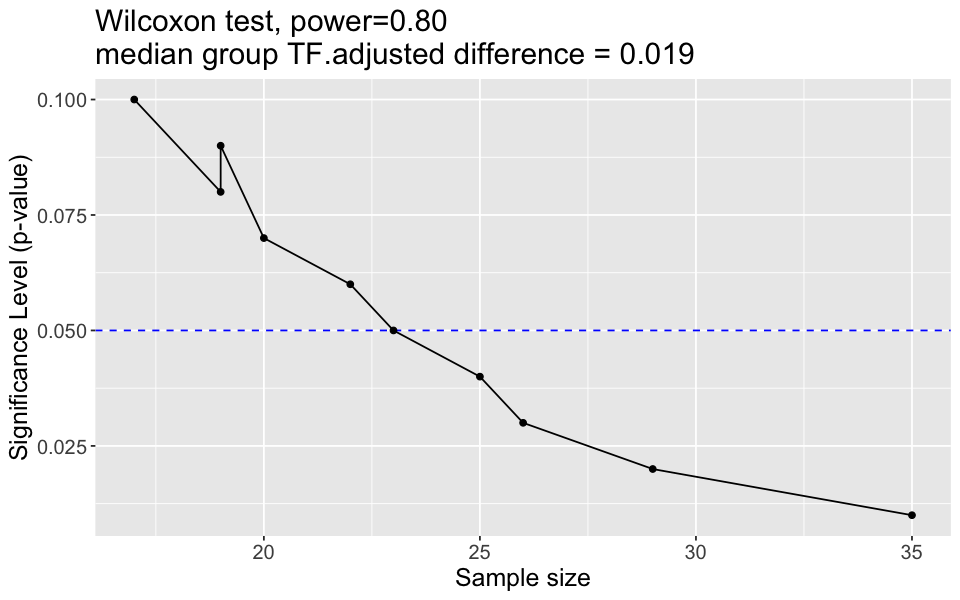

sig.level,sample.size
<dbl>,<dbl>
0.01,35
0.02,29
0.03,26
0.04,25
0.05,23
0.06,22
0.07,20
0.08,19
0.09,19


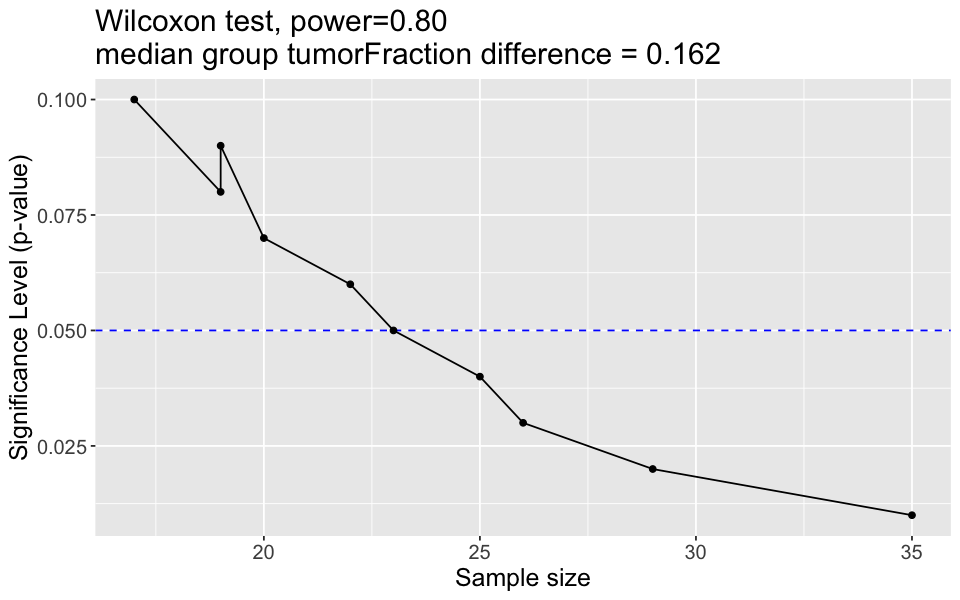

In [88]:
## BEACON tumorFraction measures
plot_MWU(df_mrd_pre$tf.m.f[df_mrd_pre$disease.positive=="TRUE"],
        df_mrd_pre$tf.m.f[df_mrd_pre$disease.positive=="FALSE"],
        power=0.80, metric="median group TF.adjusted difference")

plot_MWU(df_mrd_pre$tumorFraction[df_mrd_pre$disease.positive=="TRUE"],
        df_mrd_pre$tumorFraction[df_mrd_pre$disease.positive=="FALSE"],
        power=0.80, metric="median group tumorFraction difference")

[1] 0.055
Simulation:

Wilcoxon-Mann-Whitney Sample Size Calculation
 
Summary
Call: plot_MWU
Type-I error (two-sided): 0.01
Power: 0.8

                                Results
alpha (2-sided)               0.0100000
Power                         0.8000000
Simulated Power               0.9600000
Estimated relative effect p   0.1428571
N (total sample size needed) 27.1327432
t=n1/N                        0.7000000
n1 in Group 1                18.9929202
n2 in Group 2                 8.1398229
N rounded                    28.0000000
n1 rounded                   19.0000000
n2 rounded                    9.0000000
[1] 28
Simulation:

Wilcoxon-Mann-Whitney Sample Size Calculation
 
Summary
Call: plot_MWU
Type-I error (two-sided): 0.02
Power: 0.8

                                Results
alpha (2-sided)               0.0200000
Power                         0.8000000
Simulated Power               0.9200000
Estimated relative effect p   0.1428571
N (total sample size needed) 22.8659188
t=n1/N   

sig.level,sample.size
<dbl>,<dbl>
0.01,28
0.02,24
0.03,22
0.04,20
0.05,19
0.06,17
0.07,16
0.08,16
0.09,15


[1] 0.109
Simulation:

Wilcoxon-Mann-Whitney Sample Size Calculation
 
Summary
Call: plot_MWU
Type-I error (two-sided): 0.01
Power: 0.8

                               Results
alpha (2-sided)               0.010000
Power                         0.800000
Simulated Power               0.970000
Estimated relative effect p   0.177381
N (total sample size needed) 31.113570
t=n1/N                        0.700000
n1 in Group 1                21.779499
n2 in Group 2                 9.334071
N rounded                    32.000000
n1 rounded                   22.000000
n2 rounded                   10.000000
[1] 32
Simulation:

Wilcoxon-Mann-Whitney Sample Size Calculation
 
Summary
Call: plot_MWU
Type-I error (two-sided): 0.02
Power: 0.8

                               Results
alpha (2-sided)               0.020000
Power                         0.800000
Simulated Power               0.950000
Estimated relative effect p   0.177381
N (total sample size needed) 26.238465
t=n1/N                     

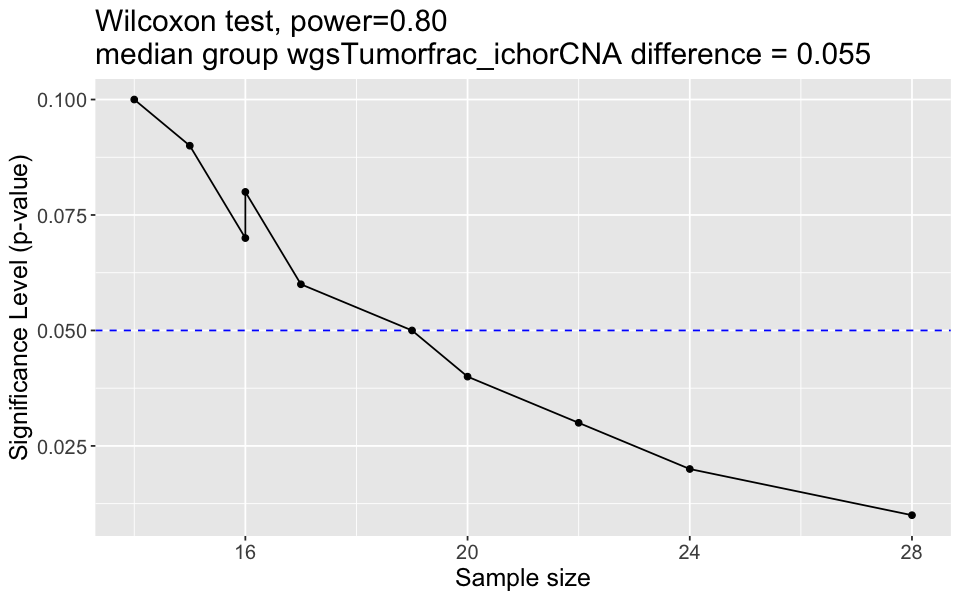

sig.level,sample.size
<dbl>,<dbl>
0.01,32
0.02,27
0.03,25
0.04,22
0.05,20
0.06,19
0.07,19
0.08,17
0.09,17


[1] 4.065
Simulation:

Wilcoxon-Mann-Whitney Sample Size Calculation
 
Summary
Call: plot_MWU
Type-I error (two-sided): 0.01
Power: 0.8

                              Results
alpha (2-sided)               0.01000
Power                         0.80000
Simulated Power               0.99000
Estimated relative effect p   0.10000
N (total sample size needed) 21.87137
t=n1/N                        0.70000
n1 in Group 1                15.30996
n2 in Group 2                 6.56141
N rounded                    23.00000
n1 rounded                   16.00000
n2 rounded                    7.00000
[1] 23
Simulation:

Wilcoxon-Mann-Whitney Sample Size Calculation
 
Summary
Call: plot_MWU
Type-I error (two-sided): 0.02
Power: 0.8

                              Results
alpha (2-sided)               0.02000
Power                         0.80000
Simulated Power               0.94000
Estimated relative effect p   0.10000
N (total sample size needed) 18.35170
t=n1/N                        0.70000
n1 in G

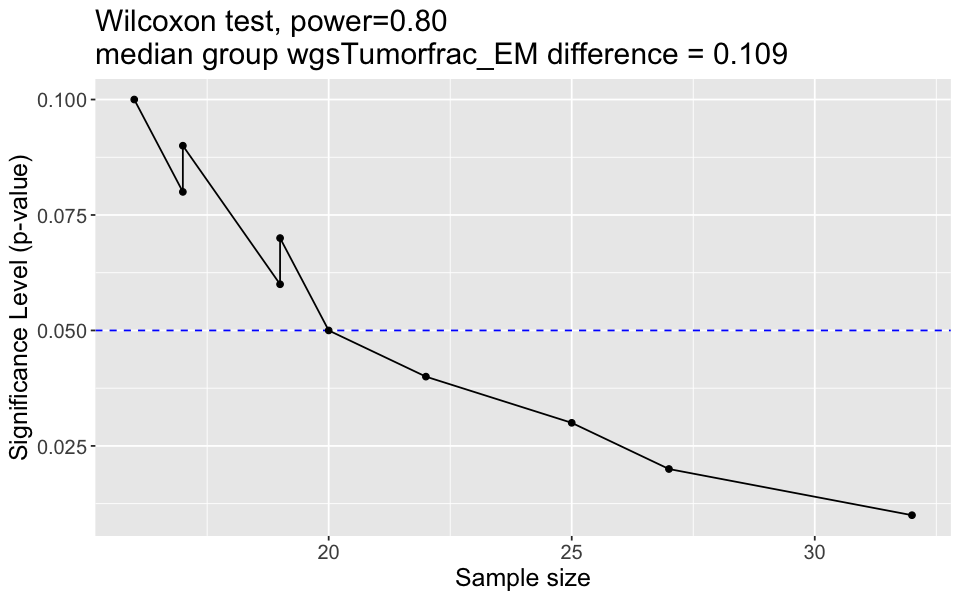

sig.level,sample.size
<dbl>,<dbl>
0.01,23
0.02,19
0.03,17
0.04,16
0.05,15
0.06,13
0.07,13
0.08,12
0.09,12


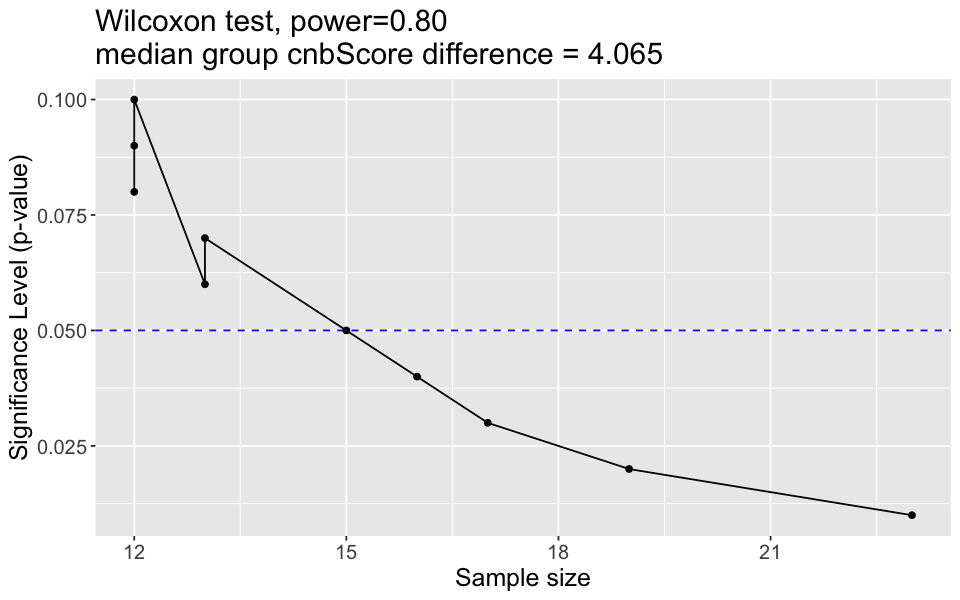

In [89]:
# LPWGS power
plot_MWU(df_urine_lpwgs_pre$wgsTumorfrac_ichorCNA[df_urine_lpwgs_pre$disease.positive=="TRUE"],
        df_urine_lpwgs_pre$wgsTumorfrac_ichorCNA[df_urine_lpwgs_pre$disease.positive=="FALSE"],
        power=0.80, metric="median group wgsTumorfrac_ichorCNA difference")

plot_MWU(df_urine_lpwgs_pre$wgsTumorfrac_EM[df_urine_lpwgs_pre$disease.positive=="TRUE"],
        df_urine_lpwgs_pre$wgsTumorfrac_EM[df_urine_lpwgs_pre$disease.positive=="FALSE"],
        power=0.80, metric="median group wgsTumorfrac_EM difference")

plot_MWU(df_urine_lpwgs_pre$cnbScore[df_urine_lpwgs_pre$disease.positive=="TRUE"],
        df_urine_lpwgs_pre$cnbScore[df_urine_lpwgs_pre$disease.positive=="FALSE"],
        power=0.80, metric="median group cnbScore difference")

## LPWGS pre-repeat urine analysis

In [129]:
# batch 1 + 2   ## panel needs TMB update
# batch 1+2: 15 total, patients 11 and 18 did not have enough FFPE for processing, 2 failed
# ffpe 50X WGS
df_ffpe_lpwgs_a = standardize_names(read.csv("./data_batch1_and_2/FFPE_WES/LPWGS/WGS_WOP00249_WOP00250_PRDC-MOFFITT-NMIBC_lpwgsQC.csv", as.is=T) %>%
                                        mutate(SampleID.short = make_SIDshort(SampleID, sid.format = "remove.suffix")),
                                    "samples", warn=F)
df_ffpe_lpwgs_a$PatientID <- fix_PIDs(df_ffpe_lpwgs_a$PatientID)
# urine LPWGS 
df_urine_lpwgs_a1 = standardize_names(read.csv("./data_batch1_and_2/Urine-UCP/Urine-LPWGS/WGS_WOP00253_254_PRDC-MOFFITT-NMIBC_lpwgsQC.csv", as.is=T) %>%
                                        mutate(SampleID.short = make_SIDshort(SampleID, sid.format = "remove.suffix")),
                             "samples", warn=F)
df_urine_lpwgs_a1$PatientID <- fix_PIDs(df_urine_lpwgs_a1$PatientID)
#df = df_all_a %>% filter(SampleType=="Supernatant") %>% filter(SampleID.short %!in% df_urine$SampleID.short)
# print(df)  # found missing samples in a2 below, bam files had been moved
# write.csv(df, "./missing_CNB_NMIBC_urine_samples.csv", row.names=F)
df_urine_lpwgs_a2 = standardize_names(read.csv("./data_batch1_and_2/Urine-UCP/Urine-LPWGS/WGS_WOP00253_WOP00254_PRDC-MOFFITT-NMIBC-22001_lpwgsQC_missing_05092023.csv", 
                                               as.is=T) %>%
                                        mutate(SampleID.short = make_SIDshort(SampleID, sid.format = "remove.suffix")), "samples", warn=F)
df_urine_lpwgs_a2$PatientID <- fix_PIDs(df_urine_lpwgs_a2$PatientID)
df_all_lpwgs_a = rbind.common(df_ffpe_lpwgs_a, rbind.common(df_urine_lpwgs_a1, df_urine_lpwgs_a2))

# batch 3
# no low pass seq data for ffpes yet
# urine samples, low pass only, mrd TBD
df_urine_lpwgs_b = read.csv("./data_batch3_02222023/WOP00634_PRDC-MOFFITT-NMIBC-22001_WGS_combined_LPWGS_QC_Summary_all.csv") %>%
                mutate("SampleID.short"=make_SIDshort(SampleID, sid.format = "remove.suffix"))
df_urine_lpwgs_b$PatientID <- fix_PIDs(df_urine_lpwgs_b$PatientID)

## combine batches
df_lpwgs_all = rbind.common(df_all_lpwgs_a, df_urine_lpwgs_b)
df_lpwgs_all = merge.combine(df_lpwgs_all, df_samples_all %>% select(PatientID, SampleID.short, SampleType, StudyVisit)) %>%
                left_join(df_clin %>% select("PatientID","disease.positive"), by="PatientID") %>%
                mutate("disease.positive"=factor(disease.positive))
stopifnot(all(!duplicated(df_lpwgs_all$SampleID)))
nrow(df_lpwgs_all) # 103
unique(df_lpwgs_all$SampleType)
unique(df_lpwgs_all$StudyVisit)

SampleID.short format: remove.suffix
 [1] "172229" "172586" "172602" "169558" "172851" "173334" "171769" "172530"
 [9] "173362" "173509" "161922" "173983"
SampleID.short format: remove.suffix
 [1] "172586" "173359" "169558" "161922" "172530" "173362" "172153" "172229"
 [9] "173334" "171374" "171769"
SampleID.short format: remove.suffix
 [1] "169558" "161922" "172530" "172602" "172851" "172586" "173983" "173359"
 [9] "173334" "171374" "173509" "171769"
SampleID.short format: remove.suffix
 [1] "175492" "152237" "173350" "175725" "171821" "174083" "182022" "174872"
 [9] "175425" "176388" "175854" "175980" "175672" "173975" "173912" "176349"
[17] "174947" "174091" "176828" "180264" "172749" "175325" "173281" "173075"
[25] "116381" "165028" "167162" "175648" "173254" "175610" "176992" "175526"
[33] "175733" "175387"
[1] "Merging columns:"
[1] "PatientID"      "SampleID.short"


[1] 103

[1] "Tissue" "Urine"

[1] "IndexTURBT"      "RepeatTURBT"     "PostTURBT"       "Surveillance1"  
[5] "Pre-RepeatTURBT" "FollowUp1"

In [131]:
df_urine_lpwgs_pre = df_lpwgs_all %>% filter(StudyVisit=="Pre-RepeatTURBT", SampleType=="Urine")
nrow(df_urine_lpwgs_pre) # 44
# df = df_urine_pre %>% 
#     select(PatientID, StudyVisit, disease.positive, wgsTumorfrac_ichorCNA) %>% arrange(PatientID)
# write.csv(df, "./pre_repeat_urine_WGS_TF_list.csv", row.names=F)
source("~/Desktop/puffin/R/helper_functions.R")

[1] 44

Complete cases wgsTumorfrac_ichorCNA by disease.positive: 37
# A tibble: 2 × 4
  disease.positive count legend       color  
  <chr>            <chr> <chr>        <chr>  
1 FALSE            13    FALSE (n=13) blue   
2 TRUE             24    TRUE (n=24)  darkred
FALSE median: 0
TRUE median: 0.07135

	Wilcoxon rank sum test with continuity correction

data:  lev1_vals and not_lev1_vals
W = 30, p-value = 3.589e-05
alternative hypothesis: true location shift is not equal to 0

  disease.positive wgsTumorfrac_ichorCNA    label
1            FALSE                0.4651 p=<0.001
2             TRUE                    NA         


Warning message:
“Removed 1 rows containing missing values (`geom_text()`).”


[1] TRUE
[1] TRUE
[1] 37
number of NA labels: 0
[1] "case/control: 27 / 13"


Setting levels: control = FALSE, case = TRUE



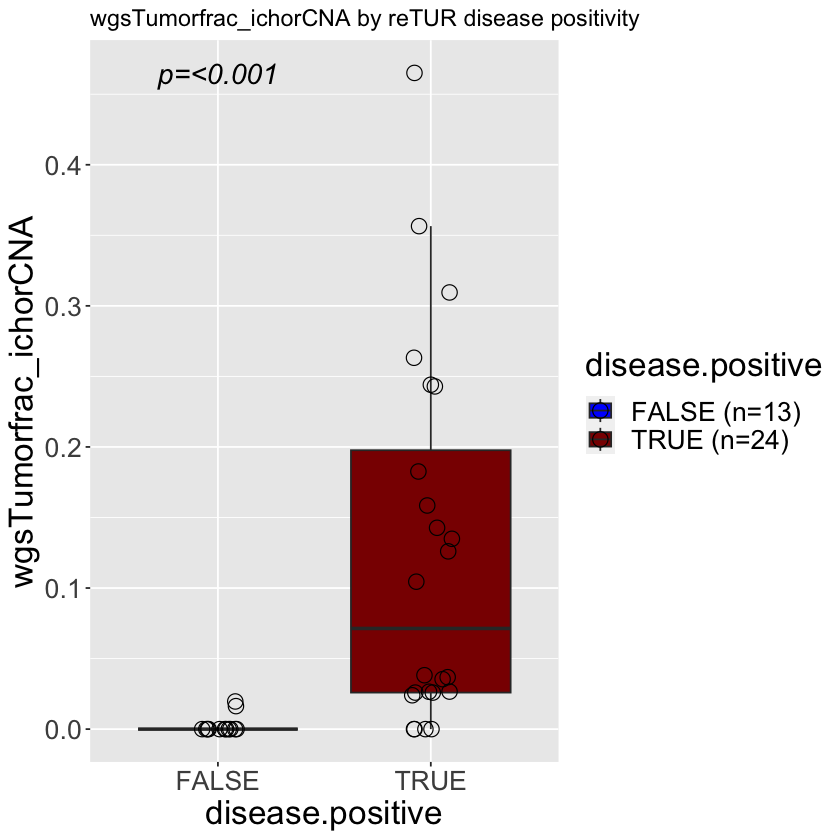

  threshold specificity sensitivity
1    0.0218           1   0.8333333
[1] "target sens 1"
  threshold specificity sensitivity
1      -Inf           0           1
[1] "AUC: 0.903846153846154"
Complete cases cnbScore by disease.positive: 37
# A tibble: 2 × 4
  disease.positive count legend       color  
  <chr>            <chr> <chr>        <chr>  
1 FALSE            13    FALSE (n=13) blue   
2 TRUE             24    TRUE (n=24)  darkred
FALSE median: 3.88570603348226
TRUE median: 8.1595036851768

	Wilcoxon rank sum test with continuity correction

data:  lev1_vals and not_lev1_vals
W = 23, p-value = 2.494e-05
alternative hypothesis: true location shift is not equal to 0

  disease.positive cnbScore    label
1            FALSE 10.80927 p=<0.001
2             TRUE       NA         


Warning message:
“Removed 1 rows containing missing values (`geom_text()`).”


[1] TRUE
[1] TRUE
[1] 37
number of NA labels: 0
[1] "case/control: 27 / 13"


Setting levels: control = FALSE, case = TRUE



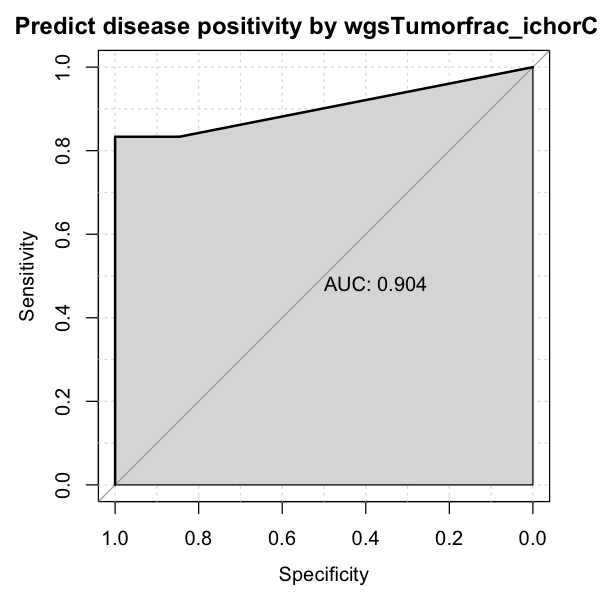

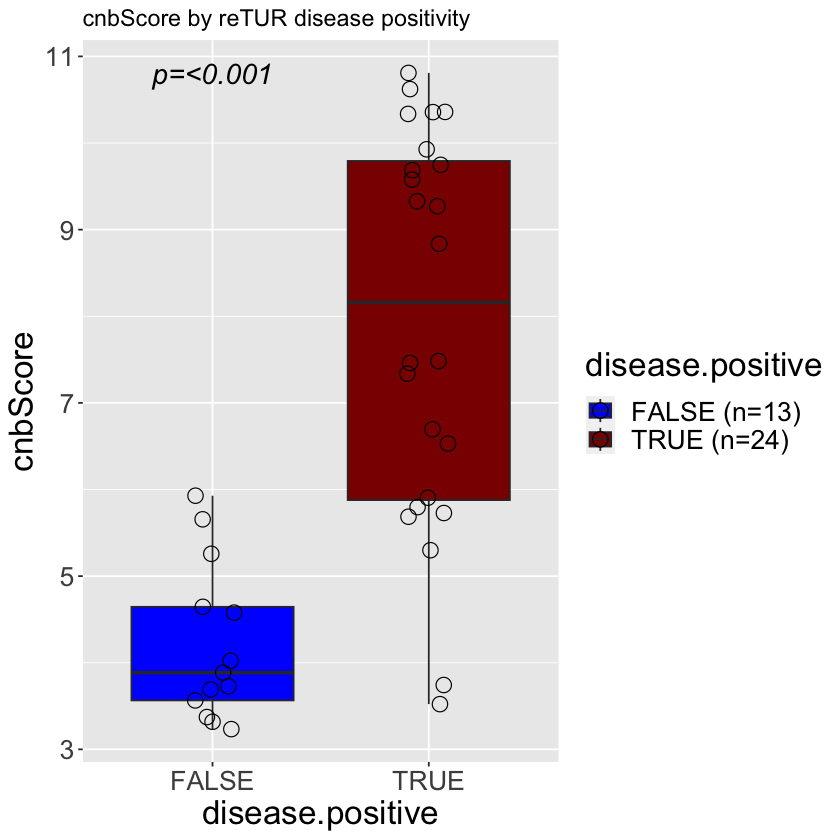

  threshold specificity sensitivity
1  5.670669   0.9230769       0.875
[1] "target sens 1"
  threshold specificity sensitivity
1  3.447388   0.2307692           1
[1] "AUC: 0.926282051282051"
Complete cases wgsTumorfrac_EM by disease.positive: 37
# A tibble: 2 × 4
  disease.positive count legend       color  
  <chr>            <chr> <chr>        <chr>  
1 FALSE            13    FALSE (n=13) blue   
2 TRUE             24    TRUE (n=24)  darkred
FALSE median: 0
TRUE median: 0.10874038682539

	Wilcoxon rank sum test with continuity correction

data:  lev1_vals and not_lev1_vals
W = 45.5, p-value = 0.0001373
alternative hypothesis: true location shift is not equal to 0

  disease.positive wgsTumorfrac_EM    label
1            FALSE       0.7317695 p=<0.001
2             TRUE              NA         


Warning message:
“Removed 1 rows containing missing values (`geom_text()`).”


[1] TRUE
[1] TRUE
[1] 37
number of NA labels: 0
[1] "case/control: 27 / 13"


Setting levels: control = FALSE, case = TRUE



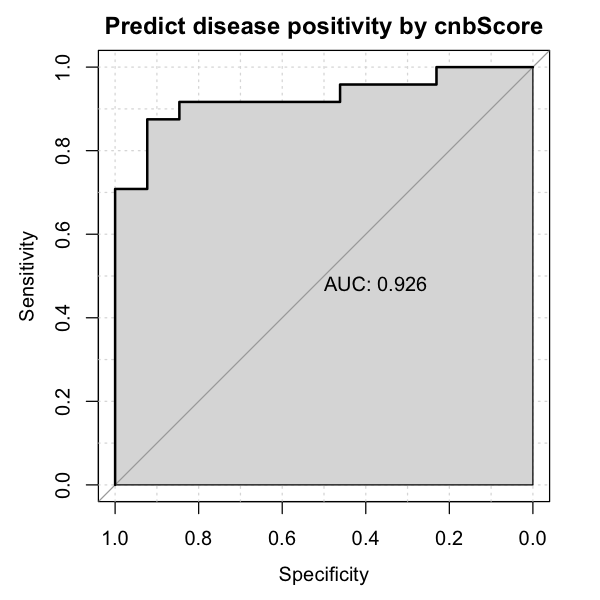

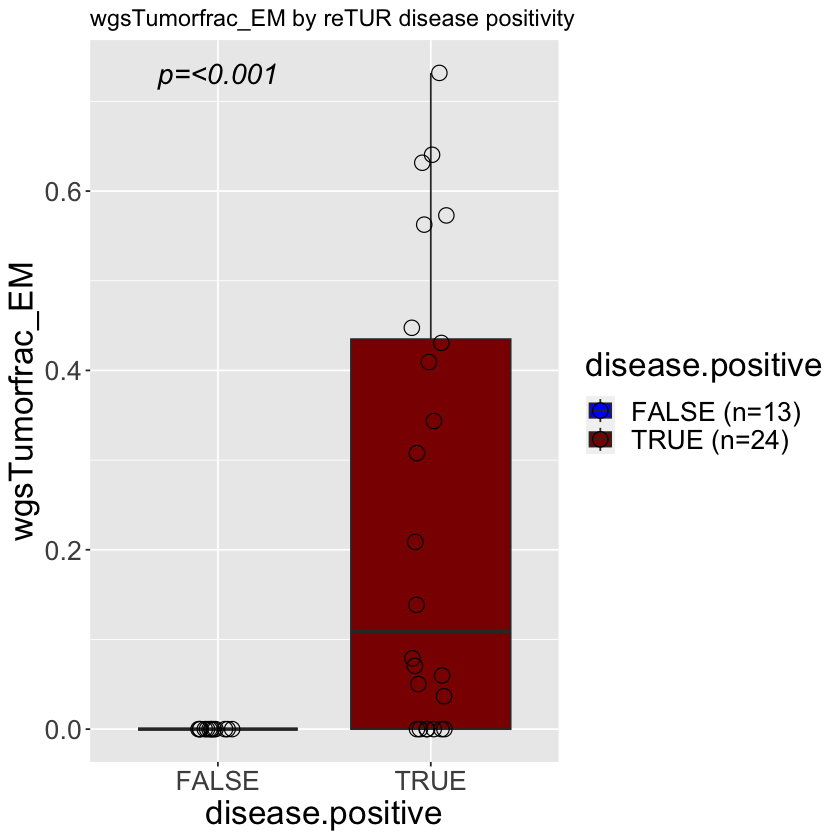

   threshold specificity sensitivity
1 0.01830617           1   0.7083333
[1] "target sens 1"
  threshold specificity sensitivity
1      -Inf           0           1
[1] "AUC: 0.854166666666667"


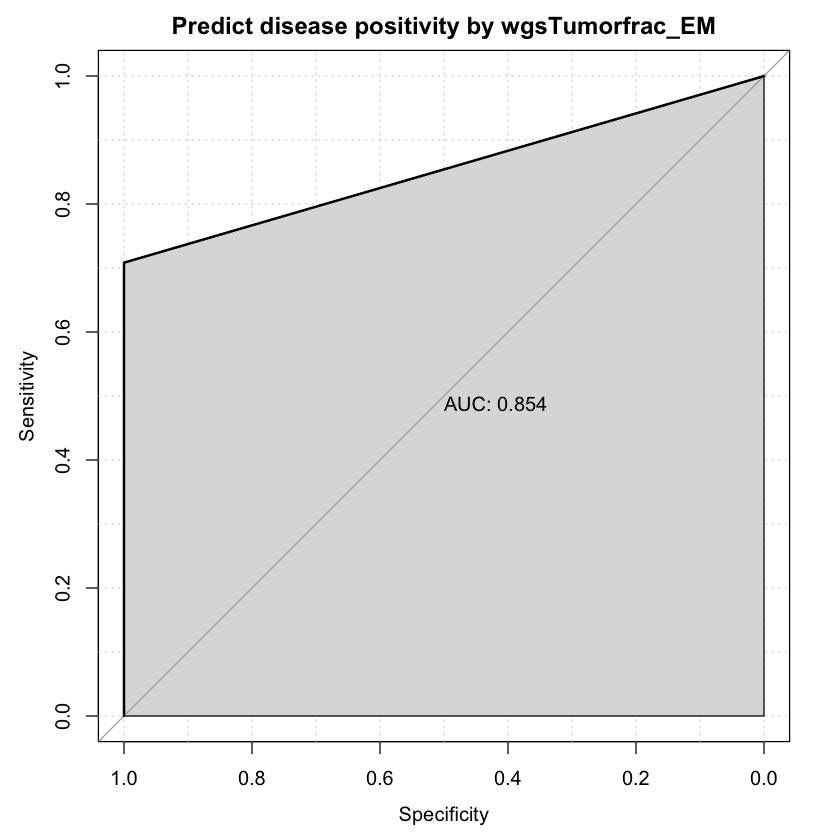

In [132]:
# correlation of LPWGS with disease positivity and prediction AUCs
for (stat in c('wgsTumorfrac_ichorCNA', 'cnbScore', 'wgsTumorfrac_EM')){
    options(repr.plot.width=5, repr.plot.height=5)
    g <- quick_boxplot(df_ngsqc.urine.mrd, x="disease.positive",y=stat, colors=c("FALSE"="blue","TRUE"="darkred"), 
                       log.axes = FALSE, plot.title = glue("{stat} by reTUR disease positivity"))
    show(g)
    options(repr.plot.width=7, repr.plot.height=7)
    get_sens_spec(df_ngsqc.urine.mrd, "disease.positive", stat, 
                  target_sens=1.0, title=glue("Predict disease positivity by {stat}"))
}

In [ ]:
# ## format for ESMO abstract
# source("~/Desktop/puffin/R/helper_functions.R")
# #pdf("./data_batch3_02222023/urine_tissue_lpwgs_tumor_fraction_05092023.pdf")
# quick_boxplot(df = df_urine_pre %>% rename("WGS.Tumor.Fraction"="wgsTumorfrac_EM"),
#               x = "disease.positive",y = "WGS.Tumor.Fraction",print.p = TRUE, colors=c("FALSE"="lightblue","TRUE"="indianred"),
#              plot.title="Pre-repeat Urine WGS Tumor Fraction (EM)")

# quick_boxplot(df = df_urine_pre %>% rename("WGS.Tumor.Fraction"="wgsTumorfrac_ichorCNA"),
#               x = "disease.positive",y = "WGS.Tumor.Fraction",print.p = TRUE, colors=c("FALSE"="lightblue","TRUE"="indianred"),
#              plot.title="Pre-repeat Urine WGS Tumor Fraction (ichor)")

# quick_boxplot(df = df_urine_pre %>% rename("cnbScore"= "Copy Number Burden"),
#               x = "disease.positive",y = "WGS.Tumor.Fraction",print.p = TRUE, colors=c("FALSE"="lightblue","TRUE"="indianred"),
#              plot.title="Pre-repeat Urine WGS Tumor Fraction (ichor)")

#dev.off()

# tissue-based MRD analysis

In [64]:
# additional samples for tissue-based pre-repeatTURB urine MRD analysis
#library(readxl)
#library(dplyr)

# all samples recieved
all.samples = make_names(read_excel("Manifest_data_all_09122023.xlsx", sheet="Sample information real time")) # from FZ
names(all.samples)
sid.to.pid = all.samples$PatientID
names(sid.to.pid) <- all.samples$SampleID
#print(sid.to.pid)

# tissue-based probe order from Aug 2023 - PD labeled them as suffix "_1" in the pipeline
probe.counts.new = read.csv("tissue_probe_mrd/Personalized_Panels_received_20230828_Pooled_MRD_panelInfo_MOFFITT_FFPE_VIP/PRDC-MOFFITT-NMIBC-22001-B_MRD_Info_2023-07-07_ffpe.csv") %>%
    mutate(group="new")
names(probe.counts.new)
nrow(probe.counts.new)
# 37 patients

# urine based probe order from Dec 2022
# 4 urine-based probe sets for samples witout tumor tissue
# probe.counts.urine = read.csv("data_batch1_and_2/FFPE_WES/Peter_analysis _files/Peter_MRD_design_12172022/Personalized_NMIBC/WOP00344_WOP00370_WOP00393_PRDC-MOFFITT-NMIBC-22001_MRD_Info_2022-12-02.csv")
# probe.counts.urine = probe.counts.urine %>% mutate(PatientID=recode(SampleID, !!!sid.to.pid),
#                                                    group="urine")
# nrow(probe.counts.urine)# 4 (one failed)
# names(probe.counts.urine)

# 6 tissue-based probe sets from Dec 2022
probe.counts.tissue = read.csv("data_batch1_and_2/FFPE_WES/Peter_analysis _files/Peter_MRD_design_12172022/Personalized_NMIBC/WOP00249_WOP00250_PRDC-MOFFITT-NMIBC-22001_MRD_Info_2022-09-23.csv")
probe.counts.tissue = probe.counts.tissue %>% mutate(PatientID=recode(SampleID, !!!sid.to.pid),
                                                    group="tissue")
nrow(probe.counts.tissue) # 12

patients.w.probes <- c(probe.counts.new$PatientID, probe.counts.tissue$PatientID)
table(patients.w.probes, useNA="always") # 50 patients

all.probe.counts = rbind.common(probe.counts.tissue, probe.counts.new)
all.probe.counts = all.probe.counts %>% left_join(all.samples %>% select(SampleID, SampleType, StudyVisit), by="SampleID")

# duplicate probe libararies
# for now don't use library from RepeatTURBTs
all.probe.counts %>% filter(PatientID=="172229")
all.probe.counts %>% filter(PatientID=="173334")

# tissue or urine only based probes for pre-repeat urine mrd and post-repeat mrd
patients.w.probes <- unique(patients.w.probes)

samples.for.mrd = all.samples %>% filter(PatientID %in% patients.w.probes,
                                         StudyVisit=="Pre-Repeat TURBT",
                                         SampleType=="Supernatant",
                                        is.na(MRD)) # has not been MRD sequenced yet
dim(samples.for.mrd)
samples.for.mrd %>% arrange(PatientID) 
# 36 samples - unknown if any of these failed extraction QC. one sample is from batch1, did we seq this one already?
write.csv(samples.for.mrd, "tissue_probe_mrd/preRepeat_urine_samles_for_tissue_mrd.csv")

#available followup urine samples for these same patients - excluding those with urine-only baseline
# samples.for.mrd = all.samples %>% filter(PatientID %in% patients.w.probes,
#                                          !grepl("TURBT", StudyVisit, ignore.case=T),
#                                          SampleType=="Supernatant",
#                                         is.na(MRD))
# dim(samples.for.mrd) # 31 followup urine samples, 
# samples.for.mrd

[1] "Order_orig"          "Order_pt"            "externalSampleID"   
 [4] "PatientID"           "StudyVisit"          "SampleType"         
 [7] "Collection.Date_new" "Batch."              "Receive.Date"       
[10] "SampleID"            "EX...QC"             "EPIC"               
[13] "MRD"                 "WES."                "MRDprobe"

[1] "PatientID"         "Panel_Name"        "SampleID"         
[4] "VariantCount.good" "VariantCount"      "VariantCount.ext" 
[7] "probeCount"        "group"

[1] 37

[1] 12

patients.w.probes
116381 152237 161922 165028 167162 169558 171769 171821 172229 172530 172586 
     1      1      1      1      1      1      1      1      2      1      1 
172602 172749 172851 173075 173281 173334 173350 173362 173509 173912 173975 
     1      1      1      1      1      2      1      1      1      1      1 
173983 174083 174091 174872 174947 175325 175387 175425 175492 175526 175610 
     1      1      1      1      1      1      1      1      1      1      1 
175648 175672 175725 175733 175854 175980 176349 176388 176828 176992 177967 
     1      1      1      1      1      1      1      1      1      1      1 
178886 180264 182022   <NA> 
     1      1      1      0 

PatientID,SampleID,VariantCount,probeCount,group,SampleType,StudyVisit
<dbl>,<chr>,<int>,<int>,<chr>,<chr>,<chr>
172229,P220068,60,60,tissue,Tissue,IndexTURBT
172229,P228845,68,62,new,FFPE,172229_RepeatTURBT


PatientID,SampleID,VariantCount,probeCount,group,SampleType,StudyVisit
<dbl>,<chr>,<int>,<int>,<chr>,<chr>,<chr>
173334,P220076,60,60,tissue,Tissue,IndexTURBT
173334,P228852,51,62,new,FFPE,173334_RepeatTURBT


[1] 36 15

Order_orig,Order_pt,externalSampleID,PatientID,StudyVisit,SampleType,Collection.Date_new,Batch.,Receive.Date,SampleID,EX...QC,EPIC,MRD,WES.,MRDprobe
<dbl>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<dttm>,<dbl>,<dttm>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
262,NA,06S22030087,116381,Pre-Repeat TURBT,Supernatant,2022-03-24,3,2023-02-21,P228695,NA,WOP00634,NA,NA,NA
234,NA,06S22108264,152237,Pre-Repeat TURBT,Supernatant,2022-10-19,3,2023-02-21,P228667,NA,WOP00634,NA,NA,NA
263,NA,06S22034101,165028,Pre-Repeat TURBT,Supernatant,2022-04-06,3,2023-02-21,P228696,NA,WOP00634,NA,NA,NA
264,NA,06S22033395,167162,Pre-Repeat TURBT,Supernatant,2022-04-04,3,2023-02-21,P228697,NA,WOP00634,NA,NA,NA
242,NA,06S22003270,171821,Pre-Repeat TURBT,Supernatant,2022-01-10,3,2023-02-21,P228675,NA,WOP00634,NA,WOP00873,NA
17,26,06S22017869,172602,Pre-Repeat TURBT,Supernatant,2022-02-15,1,2022-06-08,P217589,ROPM0173,ROPM0176,NA,NA,NA
258,NA,06S22022670,172749,Pre-Repeat TURBT,Supernatant,2022-02-28,3,2023-02-21,P228691,NA,WOP00634,NA,WOP00873,NA
261,NA,06S22018333,173075,Pre-Repeat TURBT,Supernatant,2022-02-16,3,2023-02-21,P228694,NA,WOP00634,NA,WOP00873,NA
260,NA,06S22024491,173281,Pre-Repeat TURBT,Supernatant,2022-03-07,3,2023-02-21,P228693,NA,WOP00634,NA,WOP00873,NA
